![kkbox_picture](./kkbox_picture.jpg)


The 11th ACM International Conference on Web Search and Data Mining (WSDM 2018) is challenging you to build a better music recommendation system using a donated dataset from KKBOX. WSDM (pronounced "wisdom") is one of the the premier conferences on web inspired research involving search and data mining. They're committed to publishing original, high quality papers and presentations, with an emphasis on practical but principled novel models.

---
The ideal method for music recommendation would be analyzing binary music files in addition to analysis of the structured user logs. Nevertheless, due to the substantial size of binary files as well as the lack of such open data, here we focus on providing prediction of users' preference of songs from member history. The definition for preference can be found here [Kaggle KKBOX Music Recommendation](https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data)

---
We will build a standard DNN (Dense layer) model, also called fully connected layer, as well as the structure in [Neural Collaborative Filtering](https://arxiv.org/pdf/1708.05031.pdf)and provide comparison. We also heavily use averaged embedding similar to the combiner function in [tf.feature_column.embedding_column](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column).

---
## Flow

Here we demo EDA (Explotary Data Analysis) followed by description of model and training with performance comparison as conclusion.

---
## What kind of problem to solve?

Click Throgh Rate (CTR) like or Classification problem

In [2]:
%reload_ext autoreload
%autoreload 2

import os, sys, numpy as np, pandas as pd, tensorflow as tf
import seaborn as sns

from matplotlib import pyplot as plt
# plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid') # 

ctx = os.path.abspath(os.path.dirname('.'))
if ctx not in sys.path:
    sys.path.insert(0, ctx)

from trainer.utils import utils, utils_nb
from trainer import app_conf, metadata, input as inp, service
from trainer.ctrl import Ctrl

np.set_printoptions(precision=4, suppress=True, linewidth=100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Preview

### train.csv
Column | Description
--:--  | --:-- 
msno | user id
song_id | song id
source_system_tab | the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
source_screen_name | name of the layout a user sees.
source_type | an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
target | this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .
<br/>

## songs.csv
Column | Description
--:--  | --:-- 
song_id | 
song_length | in ms
genre_ids | genre category. Some songs have multiple genres and they are separated by
artist_name | 
composer | 
lyricist | 
language |
<br/>

## members.csv
Column | Description
--:--  | --:-- 
msno | 
city | 
bd | age. Note: this column has outlier values, please use your judgement.
gender | 
registered_via | registration method
registration_init_time | format %Y%m%d
expiration_date | format %Y%m%d

## song_extra_info.csv
Column | Description
--:--  | --:-- 
song_id | 
song name | the name of the song.
isrc | International Standard Recording Code, theoretically can be used as an identity of a song. However, what worth to note is, ISRCs generated from providers have not been officially verified; therefore the information in ISRC, such as country code and reference year, can be misleading/incorrect. Multiple songs could share one ISRC since a single recording could be re-published several times.

In [2]:
utils.preview('./data/train.csv')

msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
3  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
4  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   
2  JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=        my library   
3  2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=        my library   
4  3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=           explore   

    source_screen_name      source_type  target  
0              Explore  online-playlist       1  
1  Local playlist more   local-playlist       1  
2  Local playlist more   local-playlist       1  
3  Local playlist more   local-playlist       1  
4              Explore  online-playlist       1

In [3]:
utils.preview('./data/test.csv')

id                                          msno  \
0   0  V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=   
1   1  V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=   
2   2  /uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=   
3   3  1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=   
4   4  1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=   

                                        song_id source_system_tab  \
0  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=        my library   
1  y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=        my library   
2  8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=          discover   
3  ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=             radio   
4  MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=             radio   

    source_screen_name          source_type  
0  Local playlist more        local-library  
1  Local playlist more        local-library  
2                  NaN  song-based-playlist  
3                Radio                radio  
4                Radio                radio

In [4]:
utils.preview('./data/members.csv')

msno  city  bd  gender  \
0  XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=     1   0     NaN   
1  UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=     1   0     NaN   
2  D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=     1   0     NaN   
3  mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=     1   0     NaN   
4  q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=     1   0     NaN   

   registered_via  registration_init_time  expiration_date  
0               7                20110820         20170920  
1               7                20150628         20170622  
2               4                20160411         20170712  
3               9                20150906         20150907  
4               4                20170126         20170613

In [5]:
utils.preview('./data/songs.csv')

song_id  song_length  genre_ids  \
0  CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=       247640        465   
1  o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=       197328        444   
2  DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=       231781        465   
3  dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=       273554        465   
4  W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=       140329        726   

        artist_name                            composer     lyricist  language  
0  張信哲 (Jeff Chang)                                  董貞          何啟弘       3.0  
1         BLACKPINK  TEDDY|  FUTURE BOUNCE|  Bekuh BOOM        TEDDY      31.0  
2      SUPER JUNIOR                                 NaN          NaN      31.0  
3             S.H.E                                 湯小康          徐世珍       3.0  
4              貴族精選                         Traditional  Traditional      52.0

In [6]:
utils.preview('./data/song_extra_info.csv')

song_id             name          isrc
0  LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=               我們  TWUM71200043
1  ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=  Let Me Love You  QMZSY1600015
2  u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=              原諒我  TWA530887303
3  92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=          Classic  USSM11301446
4  0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=             愛投羅網  TWA471306001

## Data Exploration
#### A quick look at certain features in the data
The exploration of recommendation data here is a quick look at the normal feature of a person (e.g: `gender`, `city`, `age` ...) to see if there's any remarkable information.

- Whether popularity of songs has significant relation with `target` (Pearson Coefficient)
- Correlations between members and songs (with selected feature combinations)
    - 單變數(uni-variate): [`bd` + `gender` + `city` + `tenure`] X [`song_yy` + `language` + `song_length`]
    - 多變數欄位(multi-variate): [`bd` + `gender` + `city` + `tenure`] X [`genre_ids` + `artist_name` + `composer`]



In [3]:
%%time
_ = inp.Input.instance.clean('./data/train.csv')

2018-08-12 12:18:20,126 - trainer.input - INFO [line:30] - Clean start, is_serving: False
2018-08-12 12:18:43,518 - trainer.input - INFO [line:48] - Clean table members.
2018-08-12 12:18:44,122 - trainer.input - INFO [line:59] - Clean table songs.
2018-08-12 12:19:44,958 - trainer.input - INFO [line:78] - Clean take time 0:01:24.830091
Wall time: 1min 25s


## Add features
- Use `registration_init_time` and `expiration_date` to calculate the enrollment duration of members (`tenure`)
- Discretize age column `bd` to several buckets ==> '06-10', '10-20', '20-30', '30-40', '40-60', '60-80'
- Extract year of the song `song_yy` from `isrc` column
- Get the popularity of songs with `song_clicks`, `song_pplrty`

In [5]:
%%time
members = pd.read_pickle('./data/processed/cleaned/members.pkl')
# Rounding tenure to int and fill missing value with median
members['tenure'] = ((members.expiration_date - members.registration_init_time) / 365).round()
members['tenure'] = members.tenure.fillna( members.tenure.median() ).map(int)
bins = np.array([6, 10, 20, 30, 40, 60, 80])
age_map = pd.Series(['', '06-10', '10-20', '20-30', '30-40', '40-60', '60-80', ''])
members['msno_age_catg'] = pd.Series(np.digitize(members.bd, bins)).map(age_map)


songs = pd.read_pickle('./data/processed/cleaned/songs.pkl')
song_extra_info = pd.read_csv('./data/song_extra_info.csv').set_index('song_id')
# Although we don't put name feature for training, but it's good for exploration 
songs['name'] = song_extra_info.name.reindex(songs.song_id).values
songs['song_yy'] = (songs.isrc.str.slice(5, 7)
                         .map(lambda e: 2000 + int(e) if int(e) < 18 else 1900 + int(e), 
                              na_action='ignore'))
# Transform song_yy to songs age
age_bins = pd.Series([0, 1960, 1980, 1990, 2000, 2010, 2015])
age_map = pd.Series([0, 1960, 1980, 1990, 2000, 2010, 2015, 2018])
songs['song_yy'] = (pd.Series(np.digitize(songs.song_yy.fillna(-1), age_bins))
                      .map(age_map).map(str))

del song_extra_info

Wall time: 26.7 s


In [4]:
%%time
tr = pd.read_pickle('./data/processed/cleaned/tr.pkl')
vl = pd.read_pickle('./data/processed/cleaned/vl.pkl')
data = pd.concat([tr, vl], 0, ignore_index=True).merge(members, how='left', on='msno').merge(songs, how='left', on='song_id')
del tr, vl 

# Songs popularity and clicks
basic_stats = data.groupby('song_id').target.agg(['count', 'mean'])
basic_stats['song_clicks'] = basic_stats.pop('count')
basic_stats['song_pplrty'] = basic_stats.pop('mean')
basic_stats = basic_stats.reindex(data.song_id)
data['song_clicks'] = basic_stats.song_clicks.values
data['song_pplrty'] = basic_stats.song_pplrty.values
data['tenure'] = data.tenure.fillna(2)
# 
data = data[data.song_id.isin(songs.song_id) & data.msno.isin(members.msno)]
del basic_stats

Wall time: 19.3 s


In [5]:
data.head()

msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
2  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
3  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
4  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   

                                        song_id source_system_tab  \
0  UM5K+g04+9t1SULpbhMfEunp6bS/5AdIQs7FbDqmmBY=             radio   
1  O9ENbN0pn9UhrPpliLKdL6NbJXvr8ne4gDPEtWiCRaw=             radio   
2  8xLXY8xKz3fcOcah+0zEMWho1OprmBalG4MgT/MFbDA=             radio   
3  J6PLzbPghqmmBEbwHqz83SWKV8rxdjxFop2yT3Ch+CA=             radio   
4  Y77QSQoIkWtNb9LJISA3EbBzReKMRUCsDeWkzoe/fvA=            search   

  source_screen_name      source_type  target city  bd gender registered_via  \
0              Radio            radio       0    1   0                     7   
1              Radio            radio       0    1   0                     7   
2              Radio            radio       0    1   0                     7   
3              Radio            radio       0    1   0                     7   
4             Search  online-playlist       0    1   0                     7   

      ...      genre_ids             artist_name  \
0     ...         (359,)  (Death Cab for Cutie,)   
1     ...         (465,)          (OneRepublic,)   
2     ...         (359,)          (The Killers,)   
3     ...         (465,)           (The Script,)   
4     ...         (465,)    (Pharrell Williams,)   

                                            composer              lyricist  \
0                                (Benjamin Gibbard,)   (Benjamin Gibbard,)   
1  (Jerrod Bettis, Ryan Tedder, Tim Myers, Zachar...                   (,)   
2  (Brandon Flowers, Dave Keuning, Mark Stoermer,...                   (,)   
3                                                (,)                   (,)   
4                               (Pharrell Williams,)  (Pharrell Williams,)   

   language          isrc                  name song_yy song_clicks  \
0        52  USAT20900521         Little Bribes    2010          13   
1        52  USUM70758801              Prodigal    2010          17   
2        52  USUM70842812  The World We Live In    2010           8   
3        52  GBARL1201146               Glowing    2015          30   
4        52  USSM11400861       Come Get It Bae    2015          36   

  song_pplrty  
0       0.000  
1       0.235  
2       0.000  
3       0.300  
4       0.417  

[5 rows x 25 columns]

In [29]:
(members.msno_age_catg == '').sum() / len(members.msno_age_catg)

0.5805017004331018

The missing values in age `(msno_age_catg)` exceeds 50%. Theoretically this feature should be dropped; nevertheless, since a person's music preference is presumably (highly) relevant to the age, we decide to keep the feature. (Discussion will be provided in later sections.)

<br/>
<br/>
<br/>

## Correlation between popularity of song and target (Pearson Coefficient)

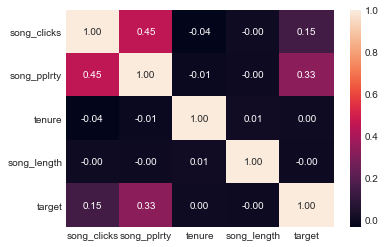

In [6]:
sns.heatmap(data[['song_clicks', 'song_pplrty', 'tenure', 'song_length', 'target']].corr(), annot=True, fmt='.2f')

Pearson Coefficient can only be used on attribute with continuous value; here we implicitly use the nominal nature of '0' and '1' from 'target' representing perference. The trend is still visible.
- `song_pplrty` is positively correlated with `target` ==> meaning recommending popular songs tends to get higher hits, which is anticipated.
- `song_pplrty` is somehow positively correlated with `song_clicks`

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

## Relation between members and songs (uni-variate)

In [7]:
# stats = utils_nb.flatten(data, ['song_yy', 'msno_age_catg', 'language'], 'genre_ids', 'target')
# 單變數(uni-variate): [bd + gender + city + tenure] X [song_yy + language + song_length]
stats = data[['msno_age_catg', 'gender', 'city', 'tenure', 'song_yy', 'language', 'song_length', 'target']].copy()
stats.head()

msno_age_catg gender city  tenure song_yy language  song_length  target
0                         1       6    2010       52   167026.000       0
1                         1       6    2010       52   235078.000       0
2                         1       6    2010       52   278453.000       0
3                         1       6    2015       52   286487.000       0
4                         1       6    2015       52   202040.000       0

### Age `msno_age_catg` and year of the song `song_yy`

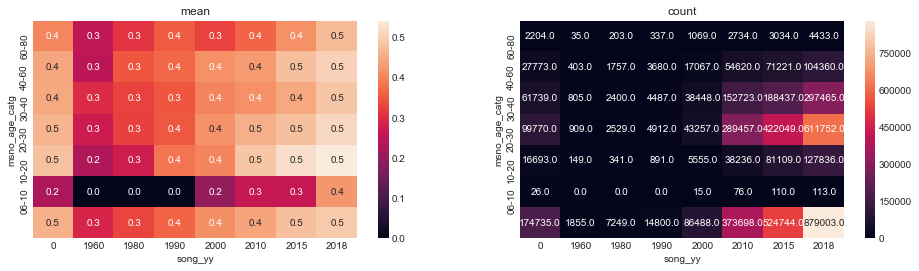

In [15]:
age_tick = ['', '06-10', '10-20', '20-30', '30-40', '40-60', '60-80']

# Remove
chop = stats # .query("msno_age_catg != '' and song_yy != '0'")
utils_nb.heatmap(chop, 'msno_age_catg', 'song_yy', annot=True, ytick=sorted(age_tick, reverse=True), fmt='.1f')

### Age `msno_age_catg` and language of song `language`

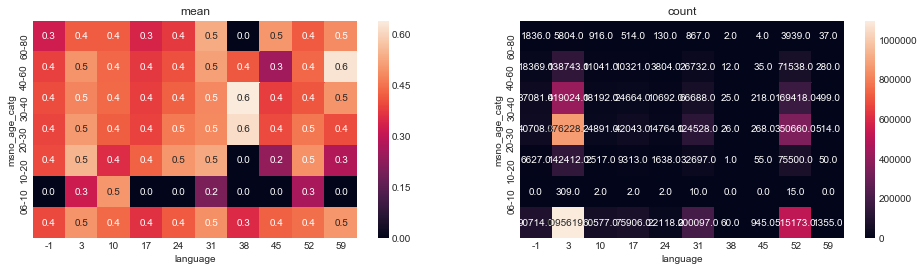

In [21]:
chop = stats # .query("msno_age_catg != ''")
utils_nb.heatmap(chop, 'msno_age_catg', 'language', annot=True,
                 xtick=('-1', '3', '10', '17', '24', '31', '38', '45', '52', '59'),
                 ytick=sorted(age_tick, reverse=True), fmt='.1f')

### Observation
- `song_yy = 0` represents song with unknown year (missing value)
- In general, most users are as expected between 20 and 30
- Songs from recent years are more popular regardless of users' age (excluding `song_yy`=0)
- Songs before 1960s are more preferable among users with greater ages, although this is not statistically significant due to the fewer user number among this age range.
- `language = 3` has the most users and popularity. Since KKBOX is a streaming service mainly for Chinese music, we assume `language 3` to be Chinese. This can be verified with song table.

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

### Age `msno_age_catg` and year of the song `song_yy` + language of song `language`

language = -1


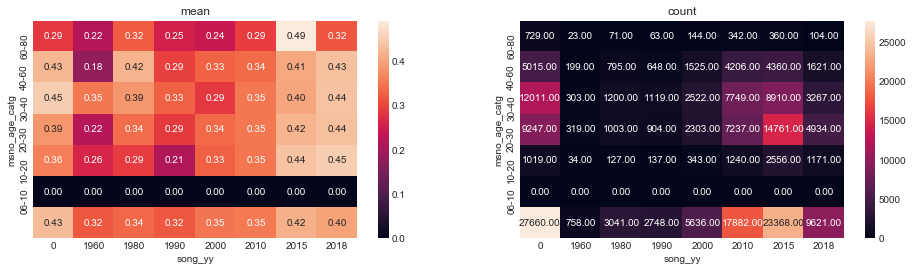

language = 3


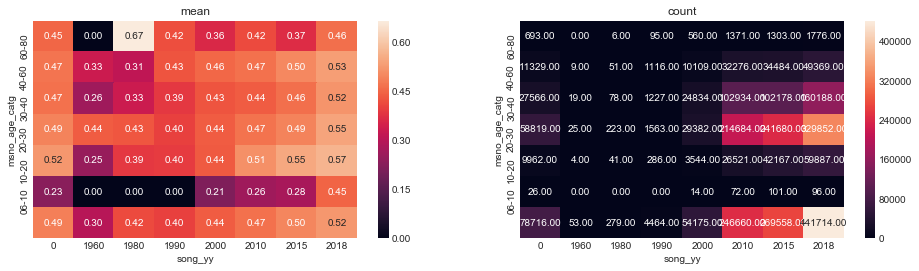

language = 10


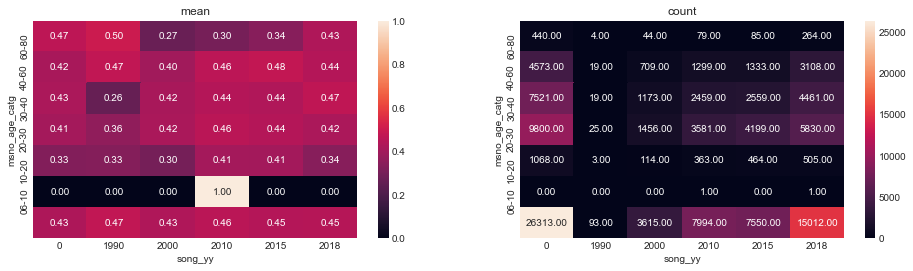

language = 17


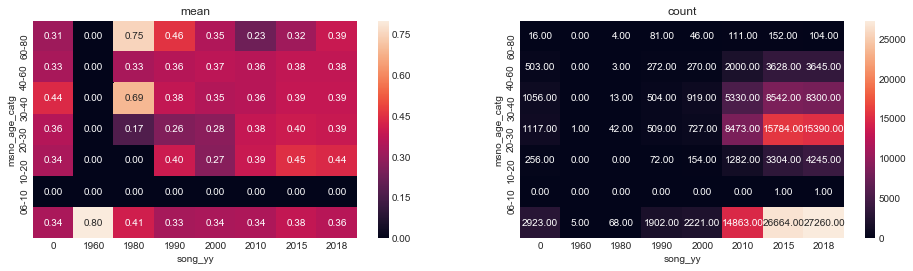

language = 24


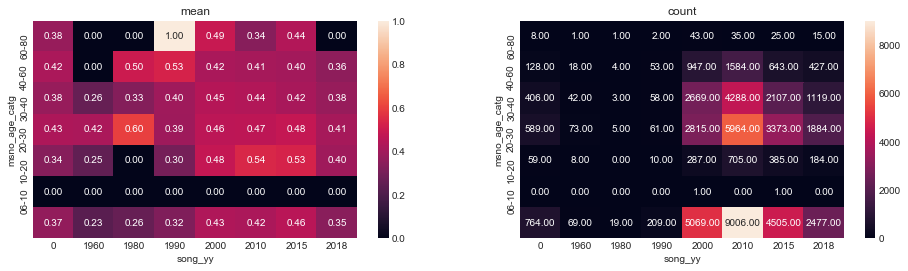

language = 31


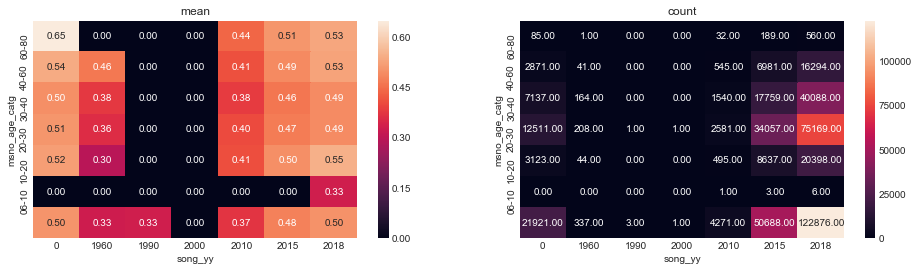

language = 38


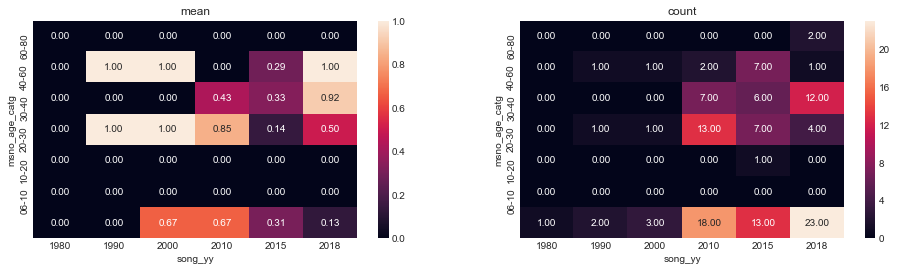

language = 45


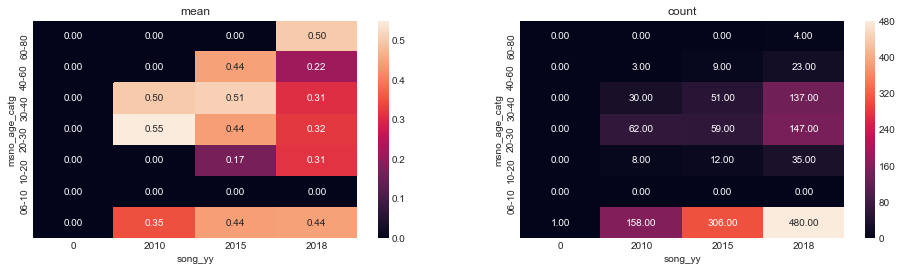

language = 52


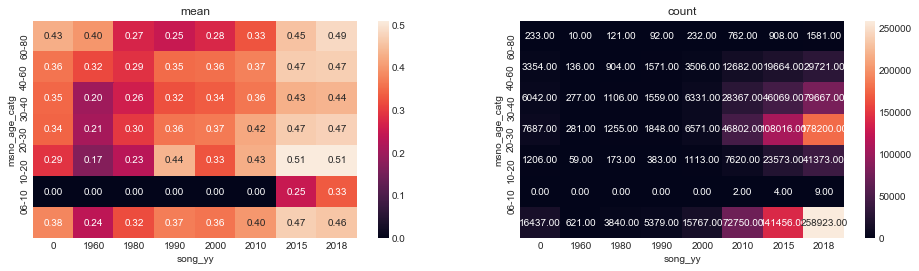

language = 59


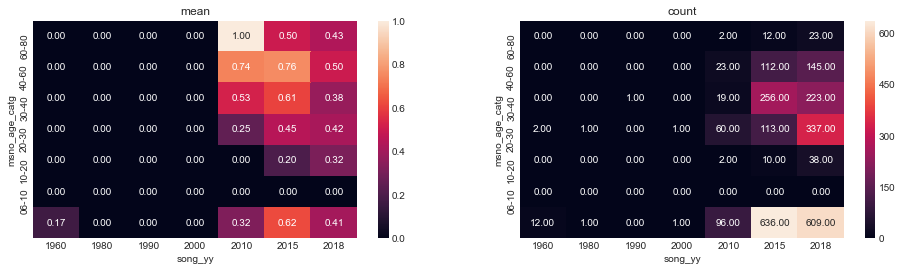

In [22]:
chop = stats # .query("msno_age_catg != '' and song_yy != '0'")
for lan in ('-1', '3', '10', '17', '24',  '31', '38', '45', '52', '59'):
    print(f'language = {lan}')
    utils_nb.heatmap(chop.query(f"language == '{lan}'"), 'msno_age_catg', 'song_yy', annot=True, ytick=sorted(age_tick, reverse=True), fmt='.2f')

### Observation (skip data with small sample size)
- `language = 17` is Japanese songs. 1980s items are popular among `30-40` and `60~80`, possibly relates to Taiwanese history with Japanese colonization in the early 20th century. 
- `language = 31` is Korean songs. Items before 1960s have higher heat stamp among higher user ages
- `language = 45` is Thai songs. No user records exist before 2010 (though songs table possess items before that year)
- `language = 24` has high click rate in 2010, verified to be Hong Kong songs from the table. `language = 38` also has high rate in the same year, but the sample size is too scarce to be statistically confident.
---
<br/>
<br/>

- It was originally expected that song listeners would remain between 20 and 40 with more higher-aged users at classic songs, although from the observation such assumptions are not significant (only on `language = 17` Japanese songs). This possibly results from the amount of missing values in `song_yy` and `bd`(`msno_age_catg`).
- The language of songs is a strong feature.


<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

### `gender` + `city` and `language` 

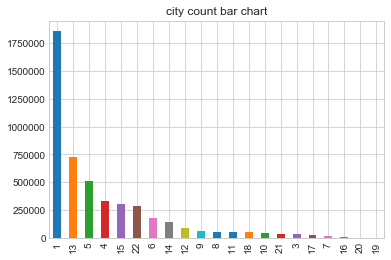

In [100]:
chop = stats.copy() # query("gender != ''")

chop.city.value_counts().plot.bar(title='city count bar chart')

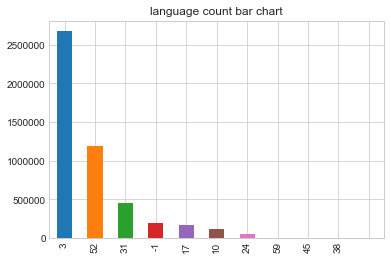

In [101]:
chop.language.value_counts().plot.bar(title='language count bar chart')

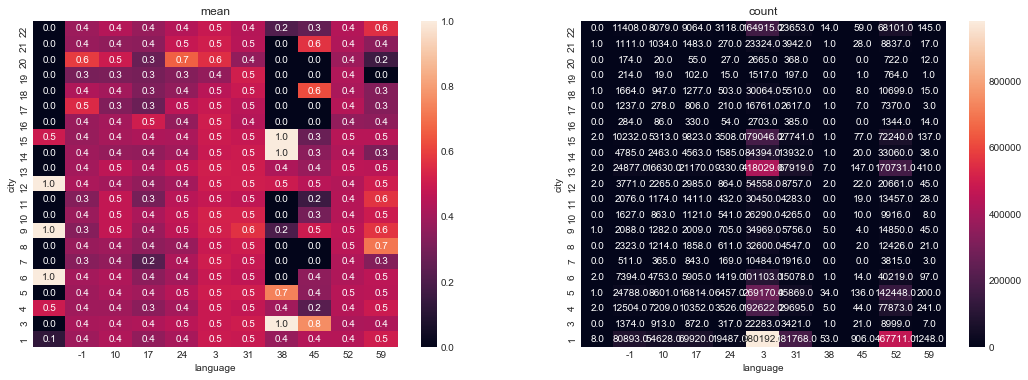

Gender: 


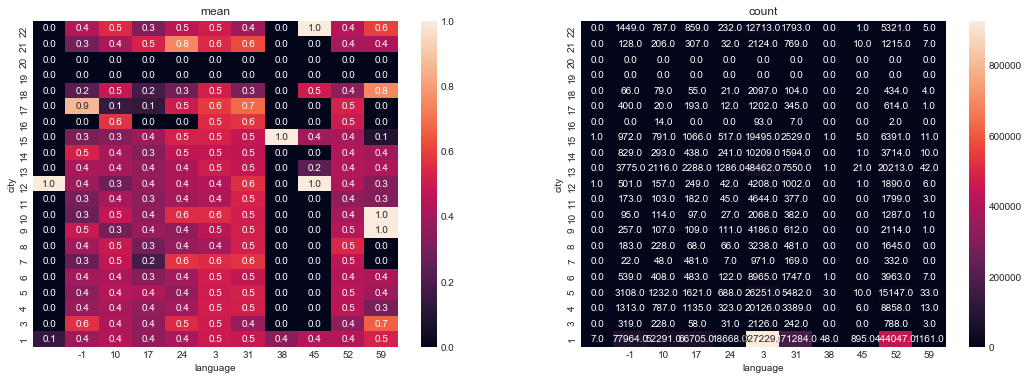

Gender: male


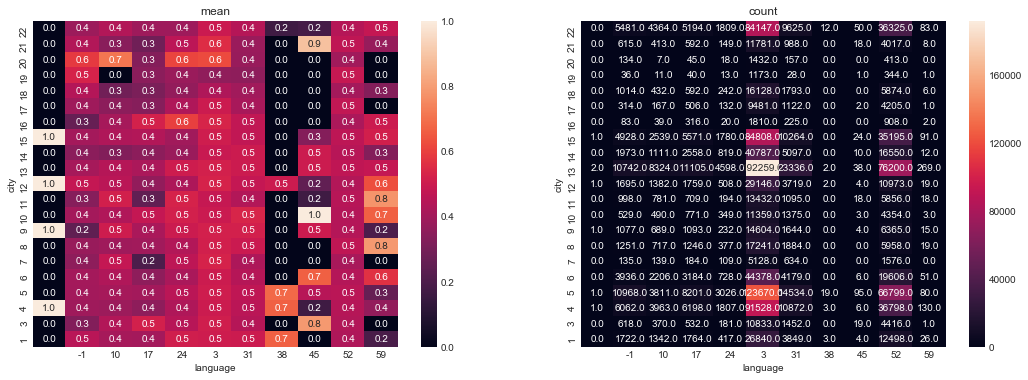

Gender: female


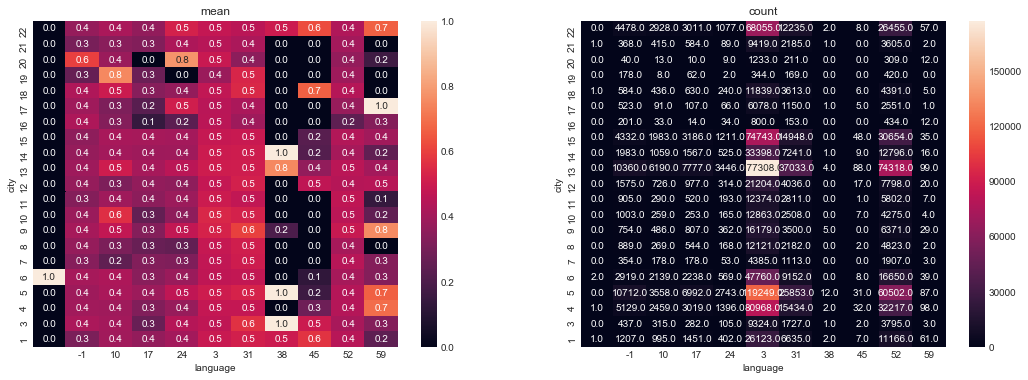

In [25]:
city_tick = list( map(str, sorted(map(int, chop.city.unique()))) )
city_tick.reverse()
utils_nb.heatmap(chop, 'city', 'language', annot=True, fmt='.1f', ytick=city_tick, figsize=(18, 6))

for gd in ('', 'male', 'female'):
    print(f'Gender: {gd}')
    utils_nb.heatmap(chop.query(f"gender == '{gd}'"), 'city', 'language', annot=True, fmt='.1f', ytick=city_tick, figsize=(18, 6))

### Observation
1. `city = 1` has most users. Heatmaps of mean with high density are mostly with smaller size of sample, therefore they are necessarily useful.
2. Frequency distributions of `city` and `language` are not uniform, making this a remarkable piece of information.

<br/>
<br/>
<br/>

### Here we focus on `genre_ids`. Due to the large number of genres, we only observe those with over 20000 click rates.

In [26]:
stats_genres = utils_nb.flatten(data, ['msno_age_catg', 'gender', 'city', 'tenure', 'song_yy', 'language', 'song_length'], 'genre_ids', 'target')
stats_genres.head()

msno_age_catg gender city  tenure song_yy language  song_length genre_ids  \
0                         1       6    2010       52   167026.000       359   
1                         1       6    2010       52   235078.000       465   
2                         1       6    2010       52   278453.000       359   
3                         1       6    2015       52   286487.000       465   
4                         1       6    2015       52   202040.000       465   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

In [30]:
genre_vc = stats_genres.genre_ids.value_counts()
print( genre_vc.describe() )

count       164.000
mean      31159.537
std      208234.426
min           1.000
25%          17.750
50%         105.500
75%        2808.000
max     2482788.000
Name: genre_ids, dtype: float64


genre_ids x msno_age_catg


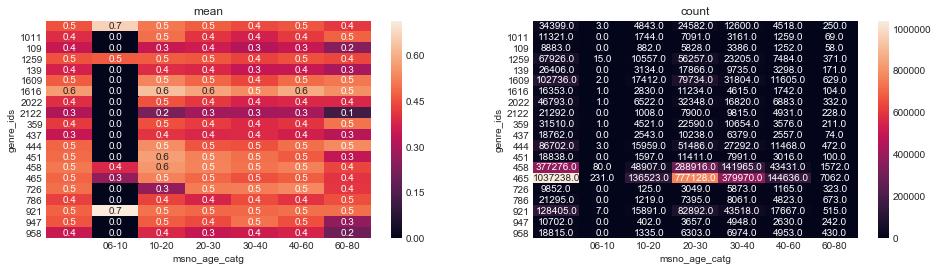

genre_ids x city


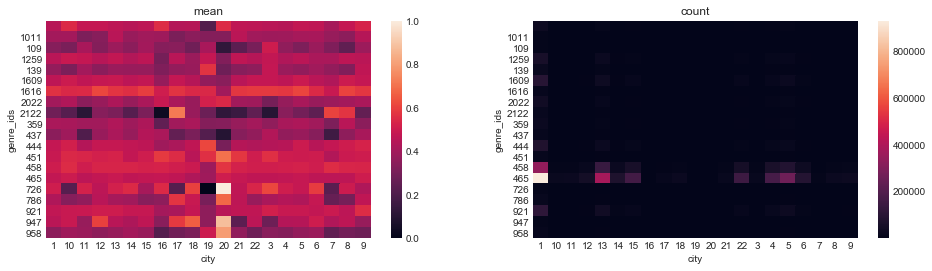

genre_ids x song_yy


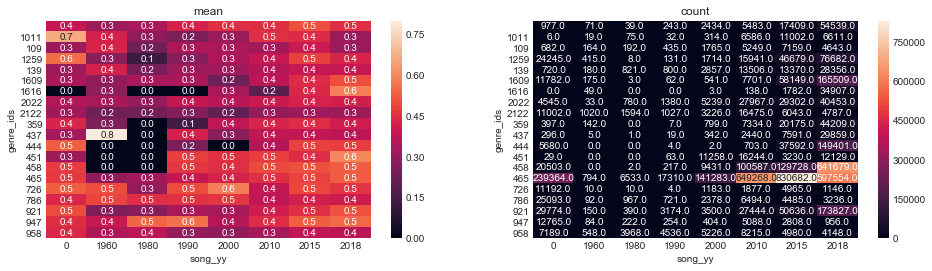

genre_ids x language


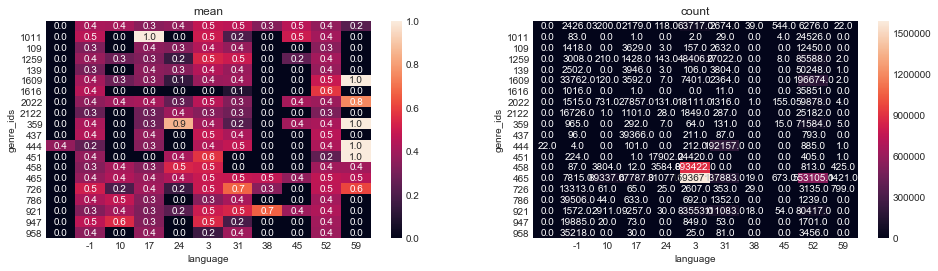

In [32]:
chop = stats_genres # .query("genre_ids != '' and msno_age_catg != ''")
genre_vc = chop.genre_ids.value_counts()
genre_vc = genre_vc[genre_vc >= 20000].index.values
print(f'genre_ids x msno_age_catg')
utils_nb.heatmap(chop[chop.genre_ids.isin(genre_vc)], 
                 'genre_ids', 'msno_age_catg', annot=True, 
                 xtick=['', '06-10', '10-20', '20-30', '30-40', '40-60', '60-80'], 
                 fmt='.1f')

print(f'genre_ids x city')
utils_nb.heatmap(chop[chop.genre_ids.isin(genre_vc)], 
                 'genre_ids', 'city', annot=False, 
                 fmt='.1f')

print(f'genre_ids x song_yy')
utils_nb.heatmap(chop[chop.genre_ids.isin(genre_vc)], 
                 'genre_ids', 'song_yy', annot=True, 
                 fmt='.1f')

print(f'genre_ids x language')
utils_nb.heatmap(chop[chop.genre_ids.isin(genre_vc)], 
                 'genre_ids', 'language', annot=True, 
                 fmt='.1f')

### Observation
- `genre_ids x msno_age_catg`: Preferences are commonly evenly distributed except for `genre = 465, 458`. Songs from`genre = 2122` are not favored in general except for age in `60-80`.
- `genre_ids x city`: No significant information
- Native data from songs:
    - `genre_ids x song_yy`, `genre_ids x language`: No significant information
    
<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

## Multivariate Feature Analysis

Before we do multivariate feature analysis, we observe `genre_ids, artist_name, composer, lyricist` separated with `|`. Outliers are expected to be seen.

In [24]:
def inspect_multi(m_col):
    ary = []
    songs[m_col].map(ary.extend)
    ary = pd.Series(ary)
    idxmax = ary.map(len).sort_values(ascending=False)[:10].index.values
    print(ary[idxmax[0]])
    
inspect_multi('artist_name')

Bernard Edwards Jr. 52 5utiLF7fh05rToE50YnkvuEOsKhJmQLxWh1w2qYKhnA 343666 Linda Ronstadt 52 sIstoLt134OfZXyetCoUqBuDas1he9uZot5EkFdp7 o 183771 921 Various Artists 52 mv3ghJbCnLEe5gEKfog 0tf8V847RpdGu1HMQKvzENc 84056 873 Reverend Lucas Noth 1 xXBADsUSxnr3UeJsjjYYGvG4xo3OCvAf HP6vgXJDq0 373307 139 Quincy Jones Rod Temperton 52 3IS9BYln6m wTPwHfZ8Msb7Cw14PjmdYKmE2l3ZL204 395389 465 Camille Camille Dalmais 52 LIWXgrPZvxwnvNwfIVaDqx4 Q4ixShpBwpoGXe4uW00 818039 958 Cyprien Katsaris 1 U B6mvGCijGdIrX6K k6uynCvdXdCRsFL8ITv k1LU 269630 465 Mega M. Nasir 59 wa9zqcTRE8wj8 IgOWg00Yg42SZmbwZzqII69kIhAAg 267493 Silent Storm 52 hwypn1FlbC9w2XJ0BPQvupKB2QzZXDvvijBPk jgy78 63251 726 Kids Choir Traditional 1 oeu8bxfD8jj SrAb1Lo9S8MxXl2IQ1SvLwnXCBGLToA 314398 2022 Thompson Teddy Thompson 52 PUxmHjMe3yH3diTS tBdjvp4Q4w8EHuV2LBCqMVECoY 183301 1609 Cameo Culture David Robertson 52 RnHUXHvDgDYh7 gCOnTrOadi6SxGs3xE 04Brp8k8o 181681 242 Chart Topping Karaoke 1 hz2hWE 2e3l6yHOmjggnWnM1i fAGSnubKGClopqZzs 170434

In [25]:
inspect_multi('composer')

Sebastian Ingrosso 52 WKCEUOm70 9O7IQ3VE2ohtiJaDGUH7cChanz4plSdA 306886 465 曹格 Gary Chaw 曹格 姚若龍 等人 3 SOicQ4b0ieAafeGqjdGVU5MPAgtYlCfGi6P49 le65I 409600 139 Slave 52 cuSwXYNpWOTM1drx mJW3qM0P5b5TY44xtrIP8DoGzQ 287093 465 J 17 I4p6lOJx ZlqcVWD5AncdwaLGfhLJ7eqm 38rSTGLjc 239281 458 于小冉 Qxygen F1ST 基械貓 3 SxekcRFJ l4MWpWZhkTsEfD0bLRpqAGZ1Y2Ed1tJ3DY 206836 465 李治廷 Aarif Rahman 李治廷 張楚翹 Solid Sound 陳考威 SpingWo 3 Dh1uPET9CjT916QXnHI1oUhnwB306jFJ xemOyU LYs 392510 2022 Megadeth Dave Mustaine 52 uQpEdgHWBjo1R8 AXlzxvzWn0Jj0jJLlpBfxi TZK00 56982 958 Peter Serkin Johann Sebastian Bach 1 QGch6e8vfa5uh7d9FvwiMpvL2SeGE0njRWnfVrUcL k 260937 465 劉錫明 Canti Lau Chow Yim Bing Zhong Qing Hong 3 K6uq5x70nj0uasA8lKfYcD3Z4XIx rDsBhld8L47q 0 164884 2022 Perfume Genius 52 eju9sOw1efXi0uGdYpeoznEaFIGnVW5JRRf8ET4oF8w 283377 fox capture plan feat. Keishi Tanaka 田中啓史 田中啓史 17 qXzFPPPO4HTgFayE4uzxWO5sll8xCHLmCursGTJYZ1Y 244826 873 Audrey Assad Audrey Assad


In [26]:
inspect_multi('lyricist')

Easy Balanced Motivated Active Determined Passionate Romantic In love Healthy Uncompromising Jazz Fusion Christmas Carols Film Music Bright Elegant Female vocal Male vocal Drums Piano Bass Saxophone Guitar acoustic Jazz band Moderately slow.A great rom


In [27]:
inspect_multi('genre_ids')

1259


Normally the names of singers or artists would not be that long, so any excessive long string after processing could be counted as outliers. The best way to deal with the issue would be converting the outliers to zero vectors; nevertheless, we do not remove the outliers here due to the tremendous effort required. Moreover, it will be very unlikely that we find the exact same outlier in future data, which means that we will not actually use the outlier embedding.

<br/>
<br/>
<br/>

### Observing artist_name
- `utils.CountMapper` ranks artists according to (descending) click rates with ascending number as index starting from 1.

In [34]:
stats_artist = utils_nb.flatten(data, ['gender', 'msno_age_catg', 'city', 'language', 'song_pplrty'], 'artist_name', 'target')
artist_mapper = utils.CountMapper(outlier='')
stats_artist['artist_name_encoded'] = artist_mapper.fit_transform(stats_artist.artist_name)
stats_artist.head()

gender msno_age_catg city language  song_pplrty          artist_name  \
0                         1       52        0.000  Death Cab for Cutie   
1                         1       52        0.235          OneRepublic   
2                         1       52        0.000          The Killers   
3                         1       52        0.300           The Script   
4                         1       52        0.417    Pharrell Williams   

   target  artist_name_encoded  
0       0                 2378  
1       0                  147  
2       0                 1536  
3       0                  508  
4       0                  551

In [102]:
artist_vc = stats_artist.artist_name.value_counts()
print(artist_vc[:10])
print( artist_vc.describe() )

Various Artists    208691
五月天 Mayday         125211
周杰倫 Jay Chou       123684
林俊傑 JJ Lin          78753
田馥甄 Hebe            74423
aMEI 張惠妹            56826
玖壹壹                 50462
陳奕迅 Eason Chan      50454
G.E.M.鄧紫棋           47893
BIGBANG             43669
Name: artist_name, dtype: int64
count    35331.000
mean       138.953
std       1958.550
min          1.000
25%          1.000
50%          3.000
75%         14.000
max     208691.000
Name: artist_name, dtype: float64


<br/>
<br/>
<br/>
We observe artists with top 100 click rates and the popularities of their songs.

h:\anaconda3\envs\py3_6\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


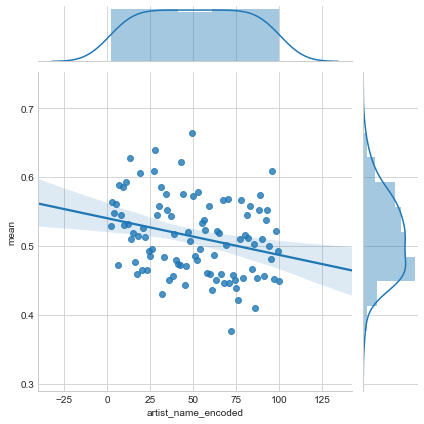

In [103]:
artist_regression = stats_artist.groupby('artist_name_encoded').target.agg(['mean', 'count']).reset_index()[1:100]
g = sns.jointplot("artist_name_encoded", "mean", data=artist_regression, kind='reg')

- Popularities range between `0 ~ 1` while center around 0.48. The data points also decrease slightly as the click rates of artists decrease (`count` grows lower to the right of plot). In short, they demonstrate a positive correlation.

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

- Now we take a closer look at the heatmaps of top 30 click rates artists while removing the top ranked `Various artists`.
- We further divide the data with ages.

In [37]:
age_tick = ['', '06-10', '10-20', '20-30', '30-40', '40-60', '60-80']

candidate_artist = artist_vc[1:30].index.values
chop = stats_artist # .query("msno_age_catg != ''")
chop = chop[chop.artist_name.isin(candidate_artist)]

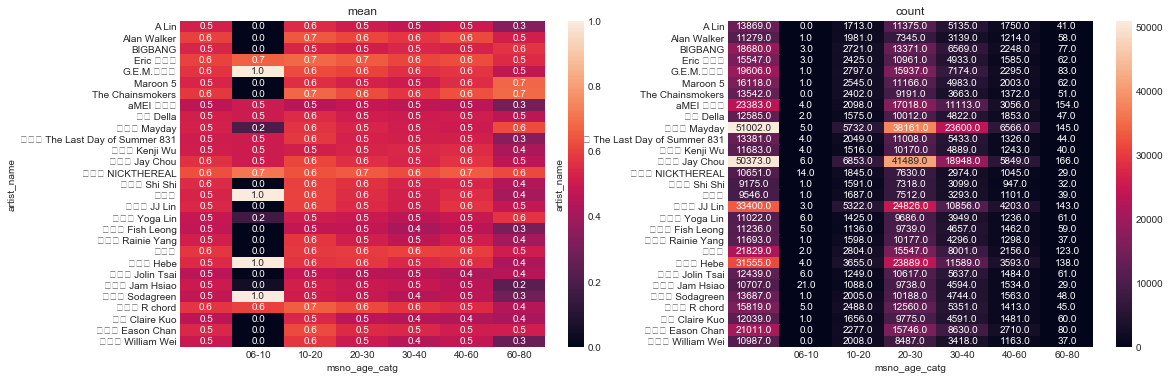

Gender: 


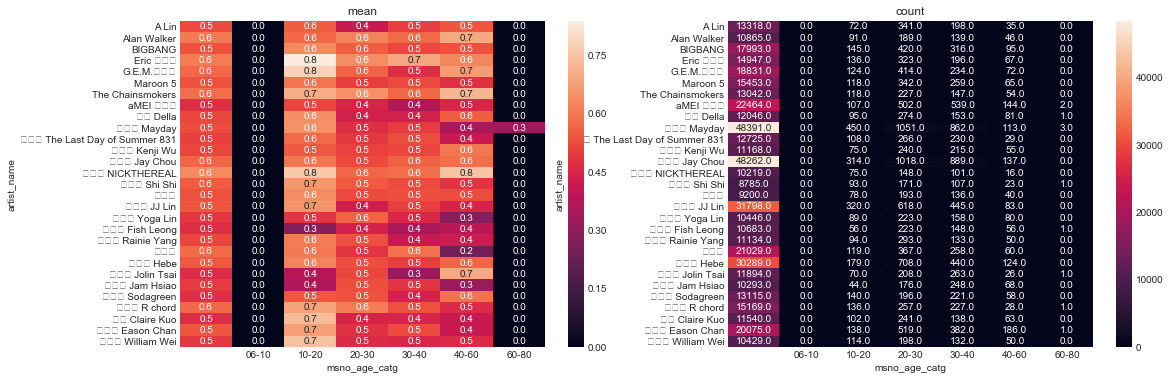

Gender: male


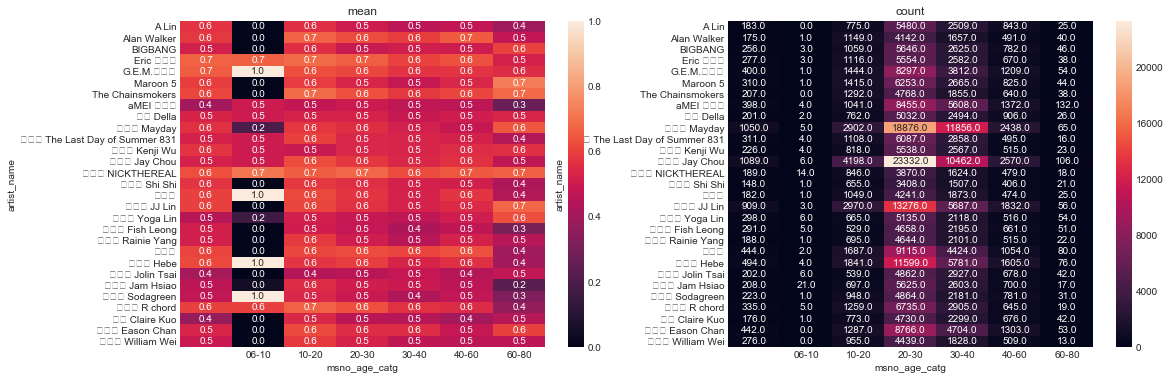

Gender: female


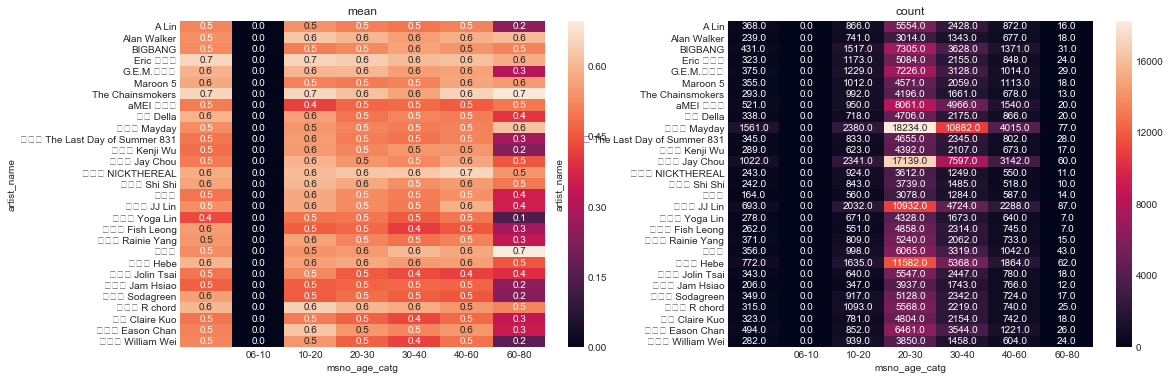

In [39]:
utils_nb.heatmap(chop, 'artist_name', 'msno_age_catg', annot=True, xtick=age_tick, fmt='.1f', figsize=(18, 6))

for gd in ('', 'male', 'female'):
    print(f'Gender: {gd}')
    utils_nb.heatmap(chop.query(f"gender == '{gd}'"), 
                     'artist_name', 'msno_age_catg', annot=True, 
                     xtick=age_tick, fmt='.1f', figsize=(18, 6))

- From the data, Mayday and Jay Chou are the champions, followed by J.J Lin and Hebe.
- Even when we fix within age range 10~60 (where most data points reside) and separate the genders, the preferences are evenly distributed at 0.5~0.6 without showing any spikes.
<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

## Focusing on the composer
- `utils.CountMapper` ranks composers according to (descending) click rates with ascending number as index starting from 1.

In [40]:
stats_composer = utils_nb.flatten(data, ['gender', 'msno_age_catg', 'city', 'language', 'song_pplrty'], 'composer', 'target')
composer_mapper = utils.CountMapper(outlier='')
stats_composer['composer_encoded'] = composer_mapper.fit_transform(stats_composer.composer)
stats_composer.head()

gender msno_age_catg city language  song_pplrty          composer  target  \
0                         1       52        0.000  Benjamin Gibbard       0   
1                         1       52        0.235     Jerrod Bettis       0   
2                         1       52        0.235       Ryan Tedder       0   
3                         1       52        0.235         Tim Myers       0   
4                         1       52        0.235   Zachary Filkins       0   

   composer_encoded  
0             10920  
1              8477  
2                39  
3              2618  
4              2528

In [97]:
composer_vc = stats_composer.composer.value_counts()
print(composer_vc[:10], '\n')
print( composer_vc.describe() )

                  1070790
周杰倫                134566
阿信                  62339
林俊傑                 54838
陳皓宇                 42238
Max Martin          37368
JJ Lin              33050
TEDDY               32473
Andrew Taggart      31147
張簡君偉                30564
Name: composer, dtype: int64 

count     69096.000
mean        107.304
std        4182.736
min           1.000
25%           1.000
50%           3.000
75%          15.000
max     1070790.000
Name: composer, dtype: float64


h:\anaconda3\envs\py3_6\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


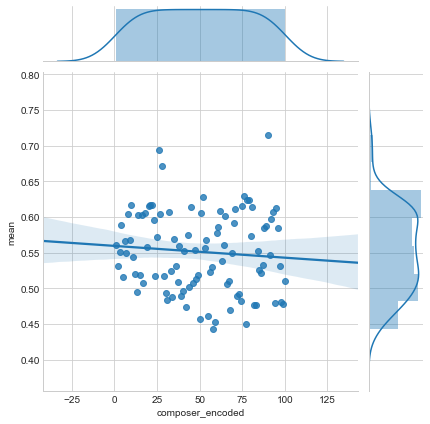

In [98]:
composer_regression = stats_composer.groupby('composer_encoded').target.agg(['mean', 'count']).reset_index()[1:101]
g = sns.jointplot("composer_encoded", "mean", data=composer_regression, kind='reg')

- Both `artist_name` and `composer` have long-tail distribution, with `composer` more severe and possesses the most missing values. Thus we skip missing values when plotting the regression line.
- The `artist_name` and `composer` demonstrates a similar trend with the click rates, while the trend for composers is milder.

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

We plot the heatmaps for the top 30 composers while skipping the missing values.

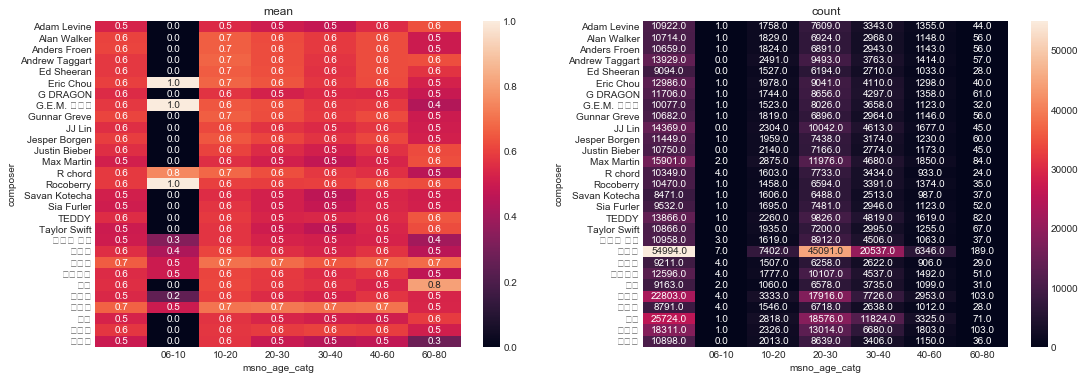

msno_age_catg             06-10    10-20     20-30     30-40    40-60   60-80
composer                                                                     
Adam Levine    10922.000  1.000 1758.000  7609.000  3343.000 1355.000  44.000
Alan Walker    10714.000  1.000 1829.000  6924.000  2968.000 1148.000  56.000
Anders Froen   10659.000  1.000 1824.000  6891.000  2943.000 1143.000  56.000
Andrew Taggart 13929.000    nan 2491.000  9493.000  3763.000 1414.000  57.000
Ed Sheeran      9094.000    nan 1527.000  6194.000  2710.000 1033.000  28.000
Eric Chou      12986.000  1.000 1978.000  9041.000  4110.000 1298.000  40.000
G DRAGON       11706.000  1.000 1744.000  8656.000  4297.000 1358.000  61.000
G.E.M. 鄧紫棋     10077.000  1.000 1523.000  8026.000  3658.000 1123.000  32.000
Gunnar Greve   10682.000  1.000 1819.000  6896.000  2964.000 1146.000  56.000
JJ Lin         14369.000    nan 2304.000 10042.000  4613.000 1677.000  45.000
Jesper Borgen  11449.000  1.000 1959.000  7438.000  3174.000 1230.000  60.000
Justin Bieber  10750.000    nan 2140.000  7166.000  2774.000 1173.000  45.000
Max Martin     15901.000  2.000 2875.000 11976.000  4680.000 1850.000  84.000
R chord        10349.000  4.000 1603.000  7733.000  3434.000  933.000  24.000
Rocoberry      10470.000  1.000 1458.000  6594.000  3391.000 1374.000  35.000
Savan Kotecha   8471.000  1.000 1606.000  6488.000  2513.000  987.000  37.000
Sia Furler      9532.000  1.000 1695.000  7481.000  2946.000 1123.000  52.000
TEDDY          13866.000  1.000 2260.000  9826.000  4819.000 1619.000  82.000
Taylor Swift   10866.000    nan 1935.000  7200.000  2995.000 1255.000  67.000
八三夭 阿璞         10958.000  3.000 1619.000  8912.000  4506.000 1063.000  37.000
周杰倫            54994.000  7.000 7402.000 45091.000 20537.000 6346.000 189.000
周湯豪             9211.000  4.000 1507.000  6258.000  2622.000  906.000  29.000
張簡君偉           12596.000  4.000 1777.000 10107.000  4537.000 1492.000  51.000
怪獸              9163.000  2.000 1060.000  6578.000  3735.000 1099.000  31.000
林俊傑            22803.000  4.000 3333.000 17916.000  7726.000 2953.000 103.000
薛之謙             8791.000  4.000 1546.000  6718.000  2638.000 1012.000  28.000
阿信             25724.000  1.000 2818.000 18576.000 11824.000 3325.000  71.000
陳皓宇            18311.000  1.000 2326.000 13014.000  6680.000 1803.000 103.000
韋禮安            10898.000    nan 2013.000  8639.000  3406.000 1150.000  36.000

In [45]:
age_tick = ['', '06-10', '10-20', '20-30', '30-40', '40-60', '60-80']

chop = stats_composer # .query("msno_age_catg != '' and composer != ''")
candicate_composer = composer_vc[1:30].index.values
chop = chop[chop.composer.isin(candicate_composer)]
utils_nb.heatmap(chop, 'composer', 'msno_age_catg', annot=True, xtick=age_tick, fmt='.1f', figsize=(18, 6))

chop.groupby(['composer', 'msno_age_catg']).target.size().reset_index().pivot('composer', 'msno_age_catg', 'target')

- A table is provided for better representation of artists with Chinese names: Composer = `周杰倫` has the highest click rates from age 10 to 60, followed by `阿信(五月天 Mayday)`. Since these two composers are actually singers who can compose, it is evident that talented singers with more skills are more popular.
- No significant information for the mean's heatmap.
- Although not having many songs, `周湯豪` and `薛之謙` both have an average song popularity of around 0.7.

<br/>
<br/>
<br/>

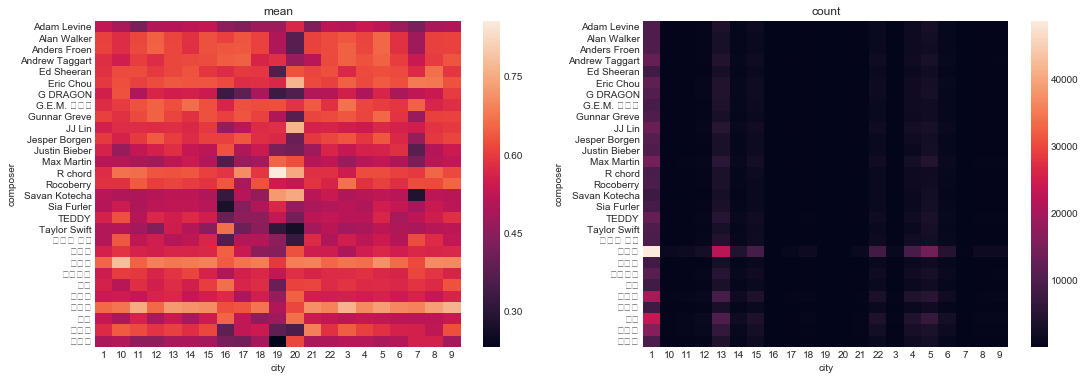

city                1    10    11    12     13    14    15   16   17    18  \
composer                                                                     
Adam Levine      9917   206   245   411   3745   698  1686   35  159   225   
Alan Walker     10043   204   256   429   3152   647  1429   23  142   227   
Anders Froen     9992   204   254   428   3135   646  1422   22  141   227   
Andrew Taggart  12915   260   363   553   4295   849  1875   28  199   304   
Ed Sheeran       8332   182   237   375   2859   598  1265   26  117   209   
Eric Chou       11849   323   303   589   4345   904  1869   29  181   304   
G DRAGON        10444   290   287   611   4250   897  1880   24  163   341   
G.E.M. 鄧紫棋       9130   261   295   545   3721   804  1709   30  148   260   
Gunnar Greve    10011   201   255   427   3144   645  1426   23  142   226   
JJ Lin          13188   328   374   644   5057   955  2183   28  207   368   
Jesper Borgen   10710   218   280   460   3374   698  1538   23  151   247   
Justin Bieber   10010   193   269   379   3295   654  1604   27  114   212   
Max Martin      14421   316   437   686   5476  1021  2423   50  229   356   
R chord          9418   215   298   522   3585   727  1567   27  155   251   
Rocoberry        9509   223   228   437   3443   677  1515   22  137   311   
Savan Kotecha    7720   178   235   374   3001   561  1234   28  106   217   
Sia Furler       8770   218   277   412   3396   722  1434   33  172   229   
TEDDY           12511   364   358   690   4849  1021  2197   20  180   394   
Taylor Swift     9955   249   255   435   3230   613  1641   24  150   205   
八三夭 阿璞           9834   292   282   621   4229   860  1838   22  159   380   
周杰倫             48619  1276  1568  2630  22323  4317  9025  111  799  1531   
周湯豪              8537   189   206   380   2896   579  1288   28  134   258   
張簡君偉            11331   304   364   639   4784   954  2070   36  185   369   
怪獸               8343   197   232   457   3376   626  1303   18   97   226   
林俊傑             20493   441   610  1091   8951  1603  3792   40  435   646   
薛之謙              7980   224   236   490   3098   676  1318   32  145   237   
阿信              23479   527   698  1382   9925  1775  3626   49  214   673   
陳皓宇             16692   453   617   993   6644  1085  2598   65  248   416   
韋禮安              9829   239   313   521   3933   738  1848   19  150   279   

city            ...    20    21    22    3     4      5     6    7     8     9  
composer        ...                                                             
Adam Levine     ...     7   209  1358  189  1543   2894   865   94   230   295  
Alan Walker     ...    16   236  1302  200  1616   2285   815   71   284   257  
Anders Froen    ...    16   236  1295  193  1599   2275   814   71   284   257  
Andrew Taggart  ...    30   244  1786  279  2049   3184  1072   87   371   392  
Ed Sheeran      ...    19   142  1150  165  1438   2242   676   66   228   249  
Eric Chou       ...    30   252  1662  252  1982   2711  1012  123   359   361  
G DRAGON        ...    11   247  1585  209  1910   2864   951  154   322   377  
G.E.M. 鄧紫棋      ...    34   236  1464  221  1761   2253   893   83   289   295  
Gunnar Greve    ...    16   235  1298  200  1611   2278   812   70   281   257  
JJ Lin          ...    30   243  1834  254  2303   3081  1151  125   310   363  
Jesper Borgen   ...    20   251  1392  210  1750   2463   864   77   304   274  
Justin Bieber   ...    17   153  1273  174  1522   2658   764   98   273   352  
Max Martin      ...    24   304  2130  317  2378   4423  1343  111   393   507  
R chord         ...    28   231  1377  215  1705   2087   993  102   294   276  
Rocoberry       ...    17   187  1242  225  1619   2125   773  101   238   283  
Savan Kotecha   ...    12   163  1145  185  1327   2378   679   56   217   276  
Sia Furler      ...    15   203  1371  167  1497   2512   784   62   226   309  
TEDDY           ...    24   294  1809  258

In [106]:
chop = stats_composer # .query("msno_age_catg != '' and composer != ''")
candicate_composer = composer_vc[1:30].index.values
chop = chop[chop.composer.isin(candicate_composer)]
utils_nb.heatmap(chop, 'composer', 'city', annot=False, fmt='.1f', figsize=(18, 6))

chop.groupby(['composer', 'city']).target.size().reset_index().pivot('composer', 'city', 'target')

- No significant information in `composer` x `city` x `target`.

<br/>
<br/>
<br/>

## Data Exploratory Conclusion
- Popularity of the song itself (`song_pplrty`, `song_clicks`) would potentially increase the likelihood of a user's preference.
- The age of KKBOX users is heavily skewed, most residing between 20 and 30.
- `language`, `song_yy` are significant features (even when they are not directly relate to the target in a linear fashion), and newer songs are generally more favorable than the old ones.
---

Since this is the data for a personal recommendation system, a general EDA (Exploratory Data Analysis) is not capable of extracting too much information. As such, we will take into account the member history and probe the interaction between each single member and music. For the history of a single user, we will calculate the `mean` of target after performing 'groupby' on different features to obtain the `count`. When encountered categorical features, we use `Embedding` to obtain averaged vectors to present the personal preference in high dimension space.

## Module structure
    ```
    └─trainer
        │  app_conf.py
        │  ctrl.py
        │  input.py
        │  logging.yaml
        │  metadata.py
        │  model.py
        │  service.py
        └─utils
           │  flex.py
           │  utils.py
           └─ utils_nb.py
    ```
    Directory trainer contains all modules: 
    
|File Name| Purpose
|:---|:---
|[app_conf.py](trainer/app_conf.py) | Application configurations, tell where the training data is, and the model checkpoint directory. Hyperparameters are suggested to put in app_conf.py instead of passing to controller on the fly.
|[ctrl.py](trainer/ctrl.py) |The entrance of the program, accept any parameters, portable for local terminal or RESTful environment. 
|[service.py](trainer/service.py) |The business logic module behind the controller (ctrl.py) 
|[utils.py](trainer/utils/utils.py) | Utility module, some common functions are put here (like logging function). 
|[utils_nb.py](trainer/utils/utils_nb.py) | Utility module, especially about functions running on notebook
|[flex.py](trainer/utils/flex.py) | IO module, portable for local IO or GCS IO
|[metadata.py](trainer/metadata.py)|Defines: 1) task type, 2) input data header, 3) numeric and categorical feature names, 4) target feature name (and labels, for a classification task), and 5) unused feature names. 
|[input.py](trainer/input.py)| Includes: 1) data input functions to read data from .csv and tfrecords files, 2) parsing functions to convert .csv and tf.example to tensors, 3) function to implement your features custom processing and creation functionality, and 4) prediction functions (for serving the model) that accepts CSV, JSON, and tf.example instances. 
|[model.py](trainer/model.py)|Includes: 1) function to create DNNRegressor, 2) function to implement for a custom estimator model_fn. 3) include **Feature class** to assign the feature spec, the feature spec usually bind for specific model, so we put them together. 

<br/>
<br/>
<br/>

## Data preprocessing
1. Data is provided in the following files:
    ```
    │  members.csv
    │  songs.csv
    │  song_extra_info.csv
    │  test.csv
    └─ train.csv 
    ```
    
2. For data pipeline on training phase, we propose 4 steps: **Clean -> Prepare -> Fit -> Transform(Split)**
    - Clean: 
        - Fill missing value, drop unnecessary features
        - Rename features
        
    - Split:
        - Here we take the first 90% of user data for training and last 10% for validation. We originally planned to do the split AFTER transform, but that is slightly like cheating since we cannot foresee future data during serving stage ('prepare', 'fit', and 'transform' stage would all use valid data). Of course, some might argue that validation data is simply used for checking overfitting and therefore should not completely forbid the use of valid data. We do not deny this statement, though we simply want to simulate the serving situation closer to the actual scenario. This decision of using less portion of data would then for sure delivers a slightly lower performance on the valid data / test data.
        - We calculate the usage statistics and obtain the 25% and 75% quantile; logs less than 25% are not used in training data. For users exceeding 75% usage, we use the number at the 75% quantile as the maximum amount of records for those users and select only the recent ones. So if the 75% quantile falls at 300, we will selected the latest 300 records for users over 75%. We do this to avoid the impact on the models' function from data of extreme cases.
        
    - Prepare: 
        - Join "store" and "store_states" to make the **Fat table**
        - Add (and drop) certain features we mentioned in data exploration
        - Filter out certain inappropriate records, e.g. open = 0
        - Maybe persist some files

    - Fit: 
        - Persist the statistical information of numeric features
        - Persist the unique count value of categorical features
        
    - Transform:
        - Normalization
        - Convert all categorical variable to int, one-hot encoding, etc.
        - Because the scale of sales is large (hence large standard deviation), **we take logarithm of the target column**

    ---
    A data preprocess example:
    ```python
    data = self.input.clean(p.fpath, is_serving=False)
    data = self.input.prepare(data, is_serving=False)
    data = self.input.fit(data).transform(data, is_serving=False)
    self.input.split(data)
    ``` 
    
3. Special feature engineering:
   - We compile the user history with 'groupby' and use embedding average for categorical features, e.g: assuming we have user record as below (listing top 5 entries) 
    ![](./kkbox_sample.jpg)
    We will then store the user data like this:
    ```
    msno_artist_name_hist:  ('Alesso', 'Eric 周興哲', 'G.E.M.鄧紫棋', 'Jessica', 'Justin Bieber')
    msno_artist_name_count:  (1, 1, 1, 1, 1)
    msno_artist_name_mean:  (1, 0.5, 0.32, 1, 1)
    ```
    `msno_artist_name_hist` is a string array, whose elements will be indexed with number before being sent to TensorFlow to generate embedding. `msno_artist_name_count`, `msno_artist_name_mean` are the weighting features that will be fed into TensorFlow and multiplied with embedding of `msno_artist_name_hist` respectively, in this case we've added 2 features, `msno_artist_name_count x msno_artist_name_hist` and `msno_artist_name_mean x msno_artist_name_hist`
    
4. We will write the added features back to the profile table, e.g: members, songs, data from future serving stage. We can use 'DataFrame.merge to join profile table using `msno` for `members` and `song_id` for `songs` before sent to the model for prediction.

## Prepare Data: Clean, Prepare, Fit, Transform

`Ctrl.instance.prepare` contains all steps: clean, split, prepare, fit transform.

In [123]:
%%time

params = pd.Series({
    'fpath': './data/train.csv'
})
Ctrl.instance.prepare(params)

2018-08-15 14:42:03,050 - trainer.input - INFO [line:30] - Clean start, is_serving: False
2018-08-15 14:42:32,351 - trainer.input - INFO [line:48] - Clean table members.
2018-08-15 14:42:32,853 - trainer.input - INFO [line:59] - Clean table songs.
2018-08-15 14:43:37,468 - trainer.input - INFO [line:78] - Clean take time 0:01:34.414935
2018-08-15 14:43:38,826 - trainer.input - INFO [line:82] - Split start
2018-08-15 14:43:40,543 - trainer.input - INFO [line:102] - Msno data distribution 
count   30755.000
mean      239.877
std       314.131
min         1.000
25%        27.000
50%       128.000
75%       340.000
max      5819.000
dtype: float64

2018-08-15 14:43:40,545 - trainer.input - INFO [line:103] - Filter training data
2018-08-15 14:44:09,427 - trainer.input - INFO [line:111] - Split take time 0:00:30.598649
2018-08-15 14:44:10,119 - trainer.input - INFO [line:172] - Prepare start
2018-08-15 14:44:16,273 - trainer.input - INFO [line:186] - 
Do prepare_members
2018-08-15 14:44:21,9

d:\python\anaconda3\envs\py3_6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


2018-08-15 14:55:24,802 - trainer.input - INFO [line:342] - fit song_length ...
2018-08-15 14:55:25,668 - trainer.input - INFO [line:342] - fit song_pplrty ...
2018-08-15 14:55:26,687 - trainer.input - INFO [line:342] - fit song_clicks ...
2018-08-15 14:55:28,550 - trainer.input - INFO [line:353] - Fit take time 0:02:03.341788
2018-08-15 14:55:34,820 - trainer.input - INFO [line:363] - Transform start
2018-08-15 14:55:48,600 - trainer.input - INFO [line:397] - transform city, vocab_key: city ...
2018-08-15 14:55:48,607 - trainer.input - INFO [line:525] - transform take time 0:00:00.004986
2018-08-15 14:55:48,626 - trainer.input - INFO [line:397] - transform gender, vocab_key: gender ...
2018-08-15 14:55:48,633 - trainer.input - INFO [line:525] - transform take time 0:00:00.005985
2018-08-15 14:55:48,651 - trainer.input - INFO [line:397] - transform registered_via, vocab_key: registered_via ...
2018-08-15 14:55:48,657 - trainer.input - INFO [line:525] - transform take time 0:00:00.00498

d:\python\anaconda3\envs\py3_6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


2018-08-15 14:55:51,284 - trainer.input - INFO [line:525] - transform take time 0:00:02.538900
2018-08-15 14:55:51,488 - trainer.input - INFO [line:408] - transform msno_neg_query_hist, vocab_key: song_id ...
2018-08-15 14:55:53,676 - trainer.input - INFO [line:525] - transform take time 0:00:02.187680
2018-08-15 14:55:53,802 - trainer.input - INFO [line:408] - transform msno_artist_name_hist, vocab_key: artist_name ...
2018-08-15 14:55:54,654 - trainer.input - INFO [line:525] - transform take time 0:00:00.851855
2018-08-15 14:55:54,676 - trainer.input - INFO [line:408] - transform msno_composer_hist, vocab_key: composer ...
2018-08-15 14:55:56,451 - trainer.input - INFO [line:525] - transform take time 0:00:01.774145
2018-08-15 14:55:56,498 - trainer.input - INFO [line:408] - transform msno_genre_ids_hist, vocab_key: genre_ids ...
2018-08-15 14:55:56,699 - trainer.input - INFO [line:525] - transform take time 0:00:00.200042
2018-08-15 14:55:56,705 - trainer.input - INFO [line:408] - t

## Model Structure

![model structure](./kkbox_model_structure.jpg)

As mentioned, we not only use the general DNN structure (fully connected layer), we also try to incorporate structure for matrix factorization. DNN is pictured on the right, serving as our first model (DNN); the other is DNN + MF (matrix factorization) model (neu_mf). What is different from the source is we added `context feature`, such as `source_system_tab`, `source_screen_name`, and `source_type`. There are fed into the input layer through concatenation.

- General settings:
    - Loss function: sigmoid cross entropy
    - Optimizer: `tf.train.AdamOptimizer`, 
    - Learning rate: Initialize to 0.001 and use `tf.train.cosine_decay`
    - Overfitting check: check the train section, we use best checkpoint(`trainer.model.BestScoreExporter`) to avoid overfitting.
    - SeLU activation function at each layer(Self Normalization)
    - DNN Structure: `input dim -> 512 -> 128 -> 64`
        - We apply [max norm constrain](http://cs231n.github.io/neural-networks-2/#reg) to the parameters, one way of conducting regularization.
        ```python
        tf.layers.dense(factor, layer, kernel_initializer=uniform_init_fn,
                        kernel_constraint=tf.keras.constraints.max_norm(),
                        ...
        ```

- DNN Model:
    - Same as general DNN structure setting, concat [member feature, song feature, context feature] -> 512 -> 128 -> 64
    
- NEU_MF Model:
    - An `MF Part` is added. We have to pass 'members' and 'songs' through fully-connected layer to encode them to the same length for later multiplication. The settings are: 
        - [member feature] -> 32 -> 16
        - [song feature] -> 32 -> 16
        
      Two vectors multiplied element-wise => Concatenate with vector from DNN part


- During data preprocessing section we mentioned that we would obtain the statistics for users and songs, such as song popularity. Generally, specific embeddings are created to represent users; here, however, we use average embeddings from user history (`song_id`) to represent a person. This way, when we encounter previously unseen user ID in the future, we can still provide prediction for him/her as long as we have the user's history, eliminating the need to re-train model的. 
- To demonstrate the users' preference with songs, records with `target = 1` are put under `msno_pos_query_hist`, `target = 0` under `msno_neg_query_hist`.
    

<br/>
<br/>


## Training

We use `tf.estimator.Estimator` with `model_fn` as the main parameter. `model_fn` is a callback function with `features`, `label`, and `mode` as the parameters.
- features: input data, saved as python dictionary
- label: data's label feature
- mode: `tf.estimator.ModeKeys`, assigning TRAIN, EVAL, or PREDICT
`model_fn` is used to implement the graph, 


Since we are using `tf.estimator.train_and_evaluate`, we need train_spec and eval_spec in addition to the estimator.
- train_spec and eval_spec: 
  train_spec and eval_spec both require data function, a function that can deliver data in batches with a hidden loop. Here we use [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) API for data extraction; this API supports multi-core processing to speed up the IO. The example is as follows:
    ```python
    def generate_input_fn(self,
        file_names_pattern, mode, skip_header_lines=False, is_serving=False,
        batch_size=256, num_epochs=1, num_threads=4):

        buffer_size = batch_size * 2
        def _input_fn():
            num_threads = multiprocessing.cpu_count() if multi_threading else 1
            file_names = tf.matching_files(file_names_pattern)

            is_serving = True if mode == tf.estimator.ModeKeys.PREDICT else False
            dataset = tf.data.TextLineDataset(filenames=file_names)
            dataset = dataset.skip(skip_header_lines)
            dataset = dataset.map(lambda csv_row: self.parse_csv(csv_row, is_serving=is_serving))
            dataset = dataset.map(lambda features: self.get_features_target_tuple(features), 
                                  num_parallel_calls=num_threads)
            if shuffle:
                dataset = dataset.shuffle(buffer_size)
            dataset = dataset.batch(batch_size)\
                             .prefetch(buffer_size)\
                             .repeat(num_epochs)
            iterator = dataset.make_one_shot_iterator()
            features, target = iterator.get_next()
            return features, target
        return _input_fn
    ```
  The `num_threads` specifies the number of cpu cores for parallel processing of data.
  
  <br/>
  
  The examples for train / eval spec are as follows:
    ```python
    # Train spec
    train_fn = generate_input_fn(...)
    train_spec = tf.estimator.TrainSpec(
        train_fn,
        max_steps=train_steps,
    )
    # Valid spec
    valid_fn = generate_input_fn(...)
    eval_spec = tf.estimator.EvalSpec(
        valid_fn,
        steps=valid_steps,
        exporters=[exporter]
    )
    ```
  The `exporters` in EvalSpec gives you the option of choosing how to export your model during evaluation; instead of using model checkpoint files, we are using [protobufs](https://www.tensorflow.org/extend/tool_developers/#protocol_buffers) files (`.pb`). We can also customize exporter through inheriting `tf.estimator.Exporter` to write your own export logic. Here we implement `BestScoreExporter` from scratch (tensorflow 1.10 now has [BestScoreExporter](https://www.tensorflow.org/api_docs/python/tf/estimator/BestExporter) for you to call directly, unfortunately this was not available at our time of development). During evaluation we compare the metric from previous iterations, such as loss and accuracy; we ONLY export the model if the result from this evaluation is better than the previous ones.
    ```python
    class BestScoreExporter(tf.estimator.Exporter):
        # ...
        def export(self, estimator, export_path, checkpoint_path, eval_result,
             is_the_final_export):

            print(f'eval_result: {eval_result}')
            curloss = eval_result['rmspe']
            if self.best is None or self.best >= curloss:
                estimator.export_savedmodel(
                    export_path,
                    self.serving_input_receiver_fn,
                    assets_extra=self.assets_extra,
                    as_text=self.as_text,
                    checkpoint_path=checkpoint_path)
            else:
                # do nothing
    ```
    While we export the model we also implement an important function, `serving_input_receiver_fn`, to be passed to `tf.estimator.Exporter`. The function is responsible for format transformation, since very often the data format during serving period is not the same as that of data actually sent to the model. The function will return `tf.estimator.export.ServingInputReceiver`. The example is as follows:
    ```python
    def json_serving_input_fn(self):
        columns = metadata.SERVING_COLUMNS
        shapes = self.get_shape(is_serving=True)
        dtypes = metadata.SERVING_DTYPES

        inputs = OrderedDict()
        for name, shape, typ in zip(columns, shapes, dtypes):
            # Remember add batch dimension to first position of shape
            inputs[name] = tf.placeholder(shape=[None, None] if len(shape) > 0 else [None], dtype=typ, name=name)

        return tf.estimator.export.ServingInputReceiver(
            features=inputs,
            receiver_tensors=inputs
        )
    ```
    We have shown from the metadata above about how to define the dtype and shape of placeholder. Online prediction normally uses JSON; if we are dealing with batch input we can also implement csv reading, where we provide at least one csv filename as input parameter. receiver_tensors would be placeholder with dtype=string, while features are tensors with model-recognized specs.
    
    <br/>
    
- Other settings:
    - Batch size = 256
    - Train steps = 4385 (about 1 epochs)
    - Valid steps = 492 (about 1 epoch)
    - Drop out rate: 0

### DNN Model

In [ ]:
%%time

params = pd.Series({
    'reset': True,
    'model_name': 'dnn'
})
Ctrl.instance.train(params)

### Neural (DNN) + MF Model

In [ ]:
%%time

params = pd.Series({
    'reset': True,
    'model_name': 'neu_mf'
})
Ctrl.instance.train(params)

## Model Comparison
![](./kkbox_auc.jpg)
We can see from the chart that Kaggle scores based on AUC (under ROC curve). Two models give similar performance, achieving nearly 0.7 with less than 0.01 difference on AUC with 500000 pieces of valid data.

<br/>
<br/>

![](./kkbox_loss.jpg)
- Sigmoid cross entropy is used for loss. `neu_mf`(light blue line) performs slightly inferior on valid data, but the two models performed about the same during training. Loss during validation seems to be gradually overfitting; but since we are using `BestExporter`, we would not export inferior result. What is worthy of mentioning is that when loss increases, the AUC does not decrease accordingly. Whether one should use loss or AUC as the criterion for exporting model is at one's own discretion.
- We had observed the performance difference between using training data and valid data. Possible reasons are:
    - We are counting batch loss (batch size=1000) for training data
    - While we use max norm regularization, we did not use dropout here
    
  It is possible that the performance for the two phases will become more similar after using dropout. (Reference:[regularization](http://cs231n.github.io/neural-networks-2/))

## Protocol buffer file inspection
Finally we are deploying `neu_mf` model. We can use `saved_model_cli` to inspect the Protocol Buffers file after training for a better understanding of the model. This tool is handy when you are using models trained by other developers [CLI to inspect SavedModel](https://www.tensorflow.org/guide/saved_model)

In [48]:
export_dir = service.Service.instance.find_latest_expdir('neu_mf')
print( utils.cmd(f'saved_model_cli show --dir {export_dir}') )

The given SavedModel contains the following tag-sets:
serve



In [2]:
export_dir = service.Service.instance.find_latest_expdir('neu_mf')
print( utils.cmd(f'saved_model_cli show --dir {export_dir} --tag_set serve') )

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "outputs"
SignatureDef key: "serving_default"



In [3]:
export_dir = service.Service.instance.find_latest_expdir('neu_mf')
command = f'saved_model_cli show --dir {export_dir} --tag_set serve --signature_def outputs'
print( utils.cmd(command) )

The given SavedModel SignatureDef contains the following input(s):
  inputs['artist_name'] tensor_info:
      dtype: DT_INT32
      shape: (-1, -1)
      name: artist_name:0
  inputs['city'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: city:0
  inputs['composer'] tensor_info:
      dtype: DT_INT32
      shape: (-1, -1)
      name: composer:0
  inputs['expiration_date'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: expiration_date:0
  inputs['gender'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: gender:0
  inputs['genre_ids'] tensor_info:
      dtype: DT_INT32
      shape: (-1, -1)
      name: genre_ids:0
  inputs['language'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: language:0
  inputs['lyricist'] tensor_info:
      dtype: DT_INT32
      shape: (-1, -1)
      name: lyricist:0
  inputs['msno_age_catg'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: msno_age_catg:0
  inputs['msno_age_num']

### Observation
From the above we can clearly see the data type and shape of input placeholder from the exported .pb file, as well as the latest output node, `concatenate/Sigmoid:0`.

<br/>
<br/>
<br/>

## Serving
Raw data has to be transformed before being fed into the model for prediction. Most actions are the same as during the training, although without the Fit Phase.
- Clean: Process the missing values, drop unneeded columns
- Prepare: Add features as mentioned in feature engineering period
- Transform: Process column value (normalization for continuous-value attributes, one-hot encoding for categorical attributes, etc)


In [7]:
%%time
test_df = Ctrl.instance.transform(pd.Series({'fpath': './data/test.csv'}))

2018-08-16 11:04:10,191 - trainer.input - INFO [line:30] - Clean start, is_serving: True
2018-08-16 11:04:15,557 - trainer.input - INFO [line:78] - Clean take time 0:00:05.365388
2018-08-16 11:04:15,559 - trainer.input - INFO [line:173] - Prepare start
2018-08-16 11:04:15,560 - trainer.input - INFO [line:199] - Prepare take time 0:00:00
2018-08-16 11:04:15,561 - trainer.input - INFO [line:364] - Transform start
2018-08-16 11:04:49,824 - trainer.input - INFO [line:379] - transform song_id, vocab_key: song_id ...
2018-08-16 11:04:51,295 - trainer.input - INFO [line:526] - transform take time 0:00:01.454162
2018-08-16 11:04:51,365 - trainer.input - INFO [line:379] - transform source_system_tab, vocab_key: source_system_tab ...
2018-08-16 11:04:51,609 - trainer.input - INFO [line:526] - transform take time 0:00:00.242357
2018-08-16 11:04:51,655 - trainer.input - INFO [line:379] - transform source_screen_name, vocab_key: source_screen_name ...
2018-08-16 11:04:51,898 - trainer.input - INFO 

In [8]:
test_df.head()

city  gender  registered_via  registration_init_time  expiration_date  \
0     1       0               2                   0.579            0.402   
1     1       0               2                   0.579            0.402   
2     1       0               4                   0.833           -0.722   
3    16       1               1                  -2.340           -0.130   
4    16       1               1                  -2.340           -0.130   

   msno_age_catg  msno_age_num  msno_tenure  \
0              0        -0.132       -0.447   
1              0        -0.132       -0.447   
2              0        -0.132       -0.942   
3              2         0.376        2.150   
4              2         0.376        2.150   

                                 msno_pos_query_hist  \
0  (3299, 5683, 501, 5471, 305, 4151, 45, 8743, 3...   
1  (3299, 5683, 501, 5471, 305, 4151, 45, 8743, 3...   
2  (197, 34, 67, 66, 206, 1665, 2, 1628, 97315, 5...   
3  (624, 3977, 4911, 4605, 466, 1406, 1714, 1379,...   
4  (624, 3977, 4911, 4605, 466, 1406, 1714, 1379,...   

                                msno_pos_query_count     ...      \
0  (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...     ...       
1  (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...     ...       
2  (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...     ...       
3  (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...     ...       
4  (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...     ...       

   song_registered_via_count  \
0         (81, 29, 123, 188)   
1  (7, 643, 494, 1333, 1360)   
2                     (1, 2)   
3              (2, 1, 10, 2)   
4                  (1, 1, 1)   

                        song_source_screen_name_hist  \
0        (0, 3, 6, 7, 11, 12, 1, 10, 17, 2, 9, 4, 5)   
1  (0, 3, 6, 8, 7, 11, 12, 1, 10, 17, 2, 9, 4, 5,...   
2                                             (6, 1)   
3                                             (1, 4)   
4                                          (3, 1, 4)   

                       song_source_screen_name_count  \
0     (31, 3, 17, 9, 3, 4, 277, 11, 2, 21, 33, 2, 8)   
1  (247, 8, 188, 289, 52, 4, 37, 1872, 70, 5, 875...   
2                                             (1, 2)   
3                                            (3, 12)   
4                                          (1, 1, 1)   

   song_source_system_tab_hist             song_source_system_tab_count  \
0        (0, 2, 6, 5, 1, 4, 3)               (1, 52, 6, 32, 310, 2, 18)   
1  (0, 2, 6, 5, 1, 7, 4, 3, 8)  (16, 1385, 87, 53, 2008, 2, 78, 206, 2)   
2                       (2, 1)                                   (1, 2)   
3                    (6, 1, 4)                               (1, 2, 12)   
4                       (1, 4)                                   (2, 1)   

                        song_source_type_hist  \
0              (0, 4, 9, 1, 3, 2, 6, 7, 8, 5)   
1  (0, 4, 11, 9, 1, 3, 12, 2, 6, 7, 8, 5, 10)   
2                                      (1, 5)   
3                                   (1, 3, 6)   
4                                   (4, 3, 6)   

                              song_source_type_count source_system_tab  \
0             (1, 5, 29, 199, 97, 24, 2, 13, 19, 32)                 1   
1  (17, 21, 1, 49, 1399, 562, 4, 1256, 81, 47, 11...                 1   
2                                             (2, 1)                 2   
3                                         (2, 1, 12)                 4   
4                                          (1, 1, 1)                 4   

  source_screen_name source_type  
0                  1           1  
1                  1           1  
2                  0           8  
3                  4           6  
4                  4           6  

[5 rows x 69 columns]

## Local prediction
1. Transform raw input data for prediction
    - We call `Ctrl.instance.transform` to transform incoming raw data, which is merged with stored information and becomes the **Fat Table** before being fed to the model.
    ```python
    def transform(self, p):
        data = self.input.clean(fpath, is_serving=True)
        data = self.input.prepare(data, is_serving=True)
        data = self.input.transform(data, is_serving=True)
        return data
    ```
    
2. Local prediction
    - call ctrl.local_predict: simply use `tensorflow.contrib.predictor`
        ```python
        from tensorflow.contrib import predictor
        predict_fn = predictor.from_saved_model(export_dir, signature_def_key='predict')
        pred = predict_fn( ... )
        ```     
3. Handle Multivariate feature:
    - For multivariate features (such as`artist_name`), data entries often do not have the same length and therefore require padding to a uniform length before sent to TensorFlow. dataset api handles this during training, while at serving stage we use the code implementing `tf.keras.preprocessing.sequence.pad_sequences`:
    ```python
    pad = tf.keras.preprocessing.sequence.pad_sequences
    # ...
    for pos in np.arange(len(indices) - 1):
        s = datetime.now()
        start, nxt = indices[pos], indices[pos + 1]
        pipe = data[start:nxt].copy()

        for m_col in multi_cols:
            pipe[m_col] = pad(pipe[m_col], padding='post', dtype=typ).tolist()
    ```

In [62]:
%%time
params = pd.Series({
    'datasource': test_df[:10000],
    'is_src_file': True,
    'model_name': 'neu_mf'
})
pred = Ctrl.instance.local_predict(params)

INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_adam_max_norm/export/estimator/1532950716\variables\variables
2018-08-15 13:02:36,189 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_adam_max_norm/export/estimator/1532950716\variables\variables
2018-08-15 13:02:37,039 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.716429
2018-08-15 13:02:37,500 - trainer.ctrl - INFO [line:110] - 1000/10000 ...
2018-08-15 13:02:38,486 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.984682
2018-08-15 13:02:38,760 - trainer.ctrl - INFO [line:110] - 2000/10000 ...
2018-08-15 13:02:39,320 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.559011
2018-08-15 13:02:39,582 - trainer.ctrl - INFO [line:110] - 3000/10000 ...
2018-08-15 13:02:40,137 - trainer.service - INFO [line:224] - padded_batch take time: 0:00:00.553813
2018-08

## Notes
Judging from the data retrieved from Serving period, we have used a lot multivariate columns (grid contains array instead of single value), During data processing, considerable time and system resource are used, thus the prediction time is increased. In the demonstration above, we can see that prediction of 10000 samples requires 11 seconds.

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

## Deply to ml-engine
- Since the model is to be deployed on ML Engine of GCP, one requires a GCP account to obtain a service account key file, so to access GCP service from your AP server. The `trainer.app_conf.Config.api_key_path` is the path specifying where your key file is stored.
- ML Engine initializes a repository when saving ML model to provide developers the convenience of switching between different versions of model. Here, however, we leave only one version of the model in the repository; while deploying model, all other models previously stored will be deleted.

<br/>
<br/>
<br/>

Appoint key file to the `GOOGLE_APPLICATION_CREDENTIALS` environment variable

In [3]:
%%time
Ctrl.instance.set_client_secret()

2018-08-16 10:58:21,817 - trainer.ctrl - INFO [line:31] - Set env variable [GOOGLE_APPLICATION_CREDENTIALS]
Wall time: 997 µs


Here we are uploading the folder of exported model to GCS with path `gs://ml-specialized/kkbox/models`. All GCS buckets are unique, so remember to change the bucket name to your own bucket. Also, select `neu_mf` at `model_path`.

In [4]:
%%time
p = pd.Series({
    # `bucket_name` and `prefix` tell Where to place the model on cloud ==> gs://{bucket_name}/{prefix}
    'bucket_name': 'ml-specialized',
    'prefix': 'kkbox/models',
    'model_path': service.Service.instance.find_latest_expdir('neu_mf'),
})
Ctrl.instance.upload_model(p)

2018-08-16 10:58:29,154 - trainer.ctrl - INFO [line:105] - delete ml-specialized/kkbox/models/saved_model.pb
2018-08-16 10:58:29,262 - trainer.ctrl - INFO [line:105] - delete ml-specialized/kkbox/models/variables/variables.data-00000-of-00001
2018-08-16 10:58:29,344 - trainer.ctrl - INFO [line:105] - delete ml-specialized/kkbox/models/variables/variables.index
2018-08-16 10:58:29,433 - trainer.ctrl - INFO [line:109] - copy D:\Python\notebook\ml_specialized\kkbox\models\kkbox_neumf_adam_max_norm\export\estimator\1534330934/saved_model.pb to kkbox/models/saved_model.pb
2018-08-16 10:58:29,828 - trainer.ctrl - INFO [line:109] - copy D:\Python\notebook\ml_specialized\kkbox\models\kkbox_neumf_adam_max_norm\export\estimator\1534330934\variables/variables.data-00000-of-00001 to kkbox/models/variables/variables.data-00000-of-00001
2018-08-16 10:58:36,546 - trainer.ctrl - INFO [line:109] - copy D:\Python\notebook\ml_specialized\kkbox\models\kkbox_neumf_adam_max_norm\export\estimator\1534330934\

### Deploy
Here is an example of deploying model with RESTful API:
```python
def create_model_ver(self, ml, model_name, deployment_uri):
    model_uri = f'projects/{self.p.project_id}/models/{model_name}'
    now = datetime.now().strftime('%Y_%m_%d__%H_%M_%S')
    version = f'v{now}'
    
    res = ml.projects().models().versions().create(
        parent=model_uri,
        body={
            'name': version,
            'description': 'Regression model use tf.estimator.DNNRegressor',
            'deploymentUri': deployment_uri,
            'runtimeVersion': '1.8'
        }
    ).execute()
    return res
```
- ml: a GCP resource object, usually acquired with
    ```python
    from googleapiclient import discovery

    credentials = GoogleCredentials.get_application_default()
    ml = discovery.build('ml', 'v1', credentials=credentials)
    ```
- deployment_uri: the path for storing GCS model

In [5]:
%%time

p = pd.Series({
    'model_name': 'ml_specilized_kkbox',
    'deployment_uri': 'gs://ml-specialized/kkbox/models'
})
Ctrl.instance.deploy(p)

2018-08-16 11:01:27,293 - googleapiclient.discovery - INFO [line:868] - URL being requested: POST https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models?alt=json
2018-08-16 11:01:27,298 - oauth2client.transport - INFO [line:151] - Attempting refresh to obtain initial access_token
2018-08-16 11:01:27,301 - oauth2client.client - INFO [line:795] - Refreshing access_token
2018-08-16 11:01:30,048 - trainer.service - WARNING [line:142] - <HttpError 409 when requesting https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models?alt=json returned "Field: model.name Error: A model with the same name already exists.">
2018-08-16 11:01:30,053 - googleapiclient.discovery - INFO [line:868] - URL being requested: GET https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models/ml_specilized_kkbox/versions?alt=json
2018-08-16 11:01:30,372 - trainer.service - INFO [line:156] - delete model version [projects/ml-team-cloudmile/models/ml_specilized_kkbox/versions/v2018_08_14__13_22_09]
2018-

### Call deployed model
Because of the traffic volume limitation, only first 50 rows of online prediction are shown.

---
There are some limitations when using GCP online prediction. For instance, the input placeholders for a model are column-based, while online prediction requires the data to be uploaded in row-based format, as below:
```python
[
    {
        'artist_name': [99, 0],
        'city': 1,
        'composer': [1963, 0, 0, 0, 0],
        'expiration_date': 0.4019061801788267,
        'gender': 0,
        ...
    }
    {...}
    {...}
    ...
]
```

In [10]:
p = pd.Series({
    'model_name': 'ml_specilized_kkbox',
    'datasource': test_df[:50].to_dict('records')
})

Ctrl.instance.set_client_secret()
result = Ctrl.instance.online_predict(p)
result

2018-08-16 11:08:52,429 - trainer.ctrl - INFO [line:31] - Set env variable [GOOGLE_APPLICATION_CREDENTIALS]
2018-08-16 11:08:52,430 - trainer.ctrl - INFO [line:157] - Online prediction ...
2018-08-16 11:08:52,500 - googleapiclient.discovery - INFO [line:274] - URL being requested: GET https://www.googleapis.com/discovery/v1/apis/ml/v1/rest
2018-08-16 11:08:53,944 - googleapiclient.discovery - INFO [line:868] - URL being requested: POST https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models/ml_specilized_kkbox:predict?alt=json
2018-08-16 11:08:53,947 - oauth2client.transport - INFO [line:151] - Attempting refresh to obtain initial access_token
2018-08-16 11:08:53,950 - oauth2client.client - INFO [line:795] - Refreshing access_token


[0.47684165835380554,
 0.39322736859321594,
 0.15940696001052856,
 0.1160639226436615,
 0.5121883749961853,
 0.2061755508184433,
 0.1152142584323883,
 0.3252882957458496,
 0.18611955642700195,
 0.726897656917572,
 0.9225326776504517,
 0.30498313903808594,
 0.24031631648540497,
 0.406383216381073,
 0.2711843252182007,
 0.21699108183383942,
 0.35455822944641113,
 0.5358836054801941,
 0.3325696587562561,
 0.8095679879188538,
 0.8704925775527954,
 0.663239598274231,
 0.5416420102119446,
 0.7595084309577942,
 0.4691305160522461,
 0.4174230992794037,
 0.3655674159526825,
 0.2683791518211365,
 0.22014708817005157,
 0.6468249559402466,
 0.3567168712615967,
 0.4697536528110504,
 0.0690305083990097,
 0.24520550668239594,
 0.8829774260520935,
 0.34178626537323,
 0.46194952726364136,
 0.34378594160079956,
 0.3940914273262024,
 0.42199867963790894,
 0.2927764654159546,
 0.57289057970047,
 0.13157063722610474,
 0.5959039330482483,
 0.007005914580076933,
 0.29217472672462463,
 0.10900341719388962,
 0

### Observation 
A total of 69 columns are in the data, with a majority of them being multivariate features resembling the nested columns in BigQuery of GCP. As a result, a batch of 100 records submitted to online prediction would exceed the limit of one API call (`"Request payload size exceeds the limit: 1572864 bytes."`). We therefore only show 50 predictions.

<br/>
<br/>
<br/>

## Check Predictions: ROC

Here we use `Ctrl.instance.local_predict` for prediction and plot the ROC curve for both models.
- About params:
    - `datasource`: data for prediction (already cleaned, prepared, and transformed)
    - `is_src_file`: is_src_file = True represents that the datasource is ready to be fed into the model, otherwise it is only a file directory.
    - `model_name`: model to be used (`dnn`, `neu_mf`)

In [12]:
vl = pd.read_pickle('./data/processed/transformed/vl.pkl')
vl_target = vl.pop('target')

auc: 0.7080121123413056


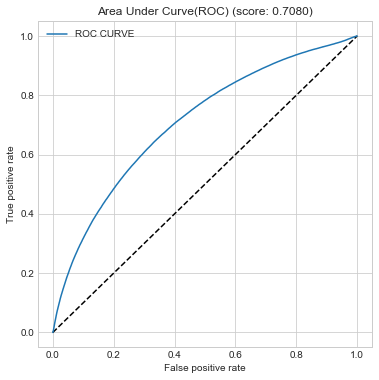

In [14]:
%%time

params = pd.Series({
    'datasource': vl,
    'is_src_file': True,
    'model_name': 'dnn'
})
pred = Ctrl.instance.local_predict(params)
utils_nb.draw_roc_curve(vl_target, pred)

auc: 0.7069878653052798


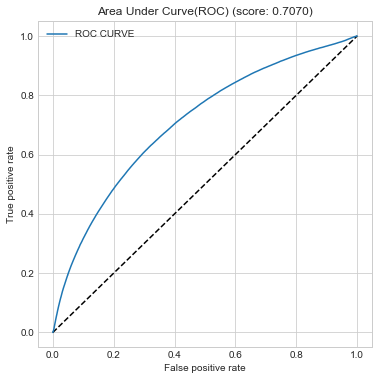

In [16]:
%%time

params = pd.Series({
    'datasource': vl,
    'is_src_file': True,
    'model_name': 'neu_mf'
})
neu_mf_pred = Ctrl.instance.local_predict(params)
utils_nb.draw_roc_curve(vl_target, neu_mf_pred)

### Observation

Both models deliver similar performance, although we expect `neu_mf` to perform better. Interestingly, when dealing with data about user behaviour, the impact from algorithm would not necessarily larger than that from feature processing, which is something worth investigating.

<br/>
<br/>
<br/>

## AUC score on training data

Since we only used batch loss and not AUC score during training phase, now we extract 500000 rows of data (same as amount of valid data) to see the AUC score.

In [3]:
tr = pd.read_pickle('./data/processed/transformed/tr.pkl')

In [7]:
data = tr.sample(500000)
target = data.pop('target')

INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_adam_max_norm/export/estimator/1534330934\variables\variables
2018-08-16 10:22:12,617 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_neumf_adam_max_norm/export/estimator/1534330934\variables\variables
2018-08-16 10:22:23,769 - trainer.ctrl - INFO [line:146] - 10000/500000 ...
2018-08-16 10:22:33,064 - trainer.ctrl - INFO [line:146] - 20000/500000 ...
2018-08-16 10:22:42,509 - trainer.ctrl - INFO [line:146] - 30000/500000 ...
2018-08-16 10:22:51,946 - trainer.ctrl - INFO [line:146] - 40000/500000 ...
2018-08-16 10:23:00,811 - trainer.ctrl - INFO [line:146] - 50000/500000 ...
2018-08-16 10:23:09,771 - trainer.ctrl - INFO [line:146] - 60000/500000 ...
2018-08-16 10:23:18,376 - trainer.ctrl - INFO [line:146] - 70000/500000 ...
2018-08-16 10:23:27,206 - trainer.ctrl - INFO [line:146] - 80000/500000 ...
2018-08-16 10:23:35,861 -

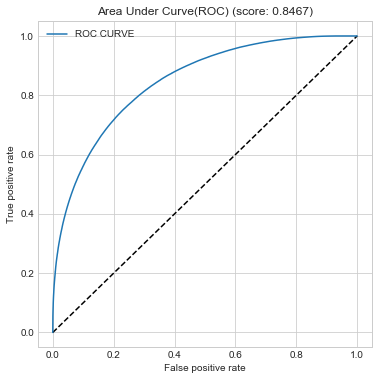

Wall time: 7min 54s


In [9]:
%%time

params = pd.Series({
    'datasource': data,
    'is_src_file': True,
    'model_name': 'neu_mf'
})
neu_mf_pred = Ctrl.instance.local_predict(params)
utils_nb.draw_roc_curve(target, neu_mf_pred)

### Observation

A 0.85 score of AUC is rather decent, different from that of valid data. The key point for further refinement would be to upgrade the model generation ability (to lower the model variance).

<br/>
<br/>
<br/>

## Room for improvement
- Moving the split stage after transform during data preprocess can improve performance (with reasons already mentioned)
- Add training steps and introduce dropout